In [1]:
# #### run once before each notebook execution and clear output
# %pip install pandas_datareader 
# %pip install statsmodels
# %pip install linearmodels
# %pip install quantstats
# %pip install wrds
# %pip install pathlib
# %pip install scipy
# %pip install sklearn
# %pip install pandas_datareader 
# %pip install tqdm
# %pip install ZipFile
# %pip install seaborn
# %pip install matplotlib
# %pip install xgboost
# %pip install quandl
# %pip install keras
# %pip install --upgrade tensorflow 
# %pip install shap
# %conda install shap

# # print('############################# completed installations #####################')

In [2]:
# after we install all the packages, import all of them for the use in today's lecture!
# database access
import boto3
from sagemaker import get_execution_role
import s3fs
import h5py
import tempfile

import quandl as quandl
import wrds as wrds
# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import seaborn as sns

# stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy import stats
from scipy.stats.mstats import winsorize
import os
from tqdm import tqdm
from zipfile import ZipFile
import seaborn
import matplotlib.pyplot as plt
import linearmodels as lm
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

#portfolio optimization:
# libraries we might use for testing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import linearmodels as lm
from linearmodels.panel import compare  
import time
import quantstats as qs
import tensorflow as tf
from tensorflow import keras
import xgboost

from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import gc

# path_factors = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factors')
# path_wrds = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\WRDS')
# path_ml = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Machine Learning Models')
# path_visual = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Visualisation/')
# path_betas = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factor Betas')

# factor_data = path_factors / 'factor_data.h5'
# macro_data = path_factors / 'macro_data.h5'
# wrds_data = path_wrds / 'wrds_data.h5'
# saved_models = path_ml / 'saved_ml_models.h5'

#bucket s3 AWS
path_bucket = 's3://mm-master-thesis-data/'
path_bucket_ml = 's3://mm-master-thesis-data/ml-models/'

#factor data 
factor_data = path_bucket + "monthly_factor_data.csv"
factor_data_adj = path_bucket + 'monthly_factors_adjusted.csv'
factor_data_base = path_bucket + 'monthly_factors_base.csv'
factor_data_base_extended = path_bucket + 'monthly_factors_base_extended.csv'

benchmark_ff = path_bucket + 'benchmark_factor_data.csv'
benchmark_bk = path_bucket + 'benchmark_factor_data_bkelly.csv'

#macro data 
macro_data = path_bucket + 'macro_data.csv'

# stock data
wrds_data_file = path_bucket +'wrds_data_complete_abs.csv' 
wrds_data_file_wins = path_bucket + 'monthly_wrds_data_complete_wins.csv'
wrds_data_file_wins_quin = path_bucket + 'monthly_stock_data_wins_quin.csv'
wrds_data_file_final = path_bucket + 'monthly_stock_data_final.csv'

#pca factors
pca_factor_path = path_bucket + 'monthly_pca_factors.csv'


# prediction results
OLS_df = path_bucket + 'ols_results.csv'
Ridge_df = path_bucket + 'ridge_results.csv'
Lasso_df = path_bucket + 'lasso_results.csv'

2022-08-28 16:02:50.078108: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-28 16:02:50.078150: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
tf.version.VERSION

'2.9.1'

In [4]:
def file_saver(data_object, data_name_as_string):
    saver = boto3.Session().resource('s3').Bucket('mm-master-thesis-data').Object(data_object).upload_file(data_name_as_string)

In [5]:
def winsorizer(df, columns, limits):
    
    winsorized_df = df.copy(deep=True)
    for c in columns:
        goods    = winsorized_df[c].notna()
        winsorized_df.loc[goods,c] = winsorize(winsorized_df.loc[goods,c], limits=limits)

    return winsorized_df

def find_min_max(df, number_of_extremes, variable):
    if isinstance(df,pd.DataFrame):

        max_df_returns = df.max().tolist()
        max_df_returns.sort(reverse=True)
        number_max_returns = max_df_returns[:number_of_extremes]
        number_max_returns = [ '%.2f' % elem for elem in number_max_returns ]
        print('The', number_of_extremes, 'highest', variable, 'are: ') 
        print(number_max_returns)
        print('')
        min_df_returns = df.min().tolist()
        min_df_returns.sort()
        number_min_returns = min_df_returns[:number_of_extremes]
        number_min_returns = [ '%.2f' % elem for elem in number_min_returns ]
        print('The', number_of_extremes, 'lowest', variable, 'are: ') 
        print(number_min_returns)
    elif isinstance(df,pd.Series):
        max_df_returns = df.values.tolist()
        max_df_returns.sort(reverse=True)
        number_max_returns = max_df_returns[:number_of_extremes]
        number_max_returns = [ '%.2f' % elem for elem in number_max_returns ]
        print('The', number_of_extremes, 'highest', variable, 'are: ') 
        print(number_max_returns)
        print('')
        min_df_returns = df.values.tolist()
        min_df_returns.sort()
        number_min_returns = min_df_returns[:number_of_extremes]
        number_min_returns = [ '%.2f' % elem for elem in number_min_returns ]
        print('The', number_of_extremes, 'lowest', variable, 'are: ') 
        print(number_min_returns)

# Macro Factors

In [6]:
macro_factors = pd.read_csv(macro_data)
macro_factors = macro_factors.set_index('date',drop=True)
macro_factors = macro_factors.applymap(lambda x: f'{x:.3f}')
macro_factors = macro_factors.drop(columns=['Unnamed: 0'])
macro_factors = macro_factors.astype(float)
macro_factors

,D12,E12,bm,tbl,lty,ntis,Rfree,infl,ltr,corpr,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
date,,,,,,,,,,,,,,,,,,,,,
1977-07,4.407,10.517,0.897,0.052,0.077,0.033,0.004,0.005,-0.007,-0.001,...,85.536,35.172,24.873,5.97,7.54,5.58,12900.00,35574.00,230.302,15.362
1977-08,4.453,10.613,0.927,0.055,0.075,0.034,0.004,0.003,0.020,0.014,...,85.817,35.270,25.027,5.99,7.56,5.61,13058.00,36030.00,230.172,14.493
1977-09,4.500,10.710,0.942,0.058,0.076,0.032,0.004,0.003,-0.003,-0.002,...,85.946,35.317,25.173,6.03,7.62,5.65,13177.00,36241.00,230.965,14.087
1977-10,4.557,10.770,0.975,0.062,0.078,0.033,0.005,0.003,-0.009,-0.004,...,86.439,35.456,25.293,6.08,7.66,5.69,14686.00,37965.00,229.856,15.454
1977-11,4.613,10.830,0.962,0.061,0.078,0.029,0.005,0.005,0.009,0.006,...,86.802,35.699,25.434,6.11,7.68,5.72,14975.00,38553.00,231.645,19.638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,59.129,98.557,0.236,0.001,0.006,-0.009,0.000,0.003,-0.035,-0.049,...,86.662,98.675,120.600,25.50,29.43,22.85,344023.25,726723.85,4385.243,22.879
2020-09,58.851,98.220,0.241,0.001,0.007,-0.006,0.000,0.001,0.008,0.004,...,86.616,98.508,120.964,25.46,29.11,23.00,347627.43,730734.42,4452.042,27.587
2020-10,58.660,96.857,0.253,0.001,0.008,-0.002,0.000,0.000,-0.024,-0.019,...,86.532,98.398,121.094,25.54,29.31,22.99,348262.68,730398.69,4514.528,29.436


# Factor Data

In [7]:
monthly_factors = pd.read_csv(factor_data)
monthly_factors= monthly_factors.set_index('date',drop=True)
monthly_factors = monthly_factors.applymap(lambda x: f'{x:.3f}')
monthly_factors= monthly_factors.astype('float')
monthly_factors= monthly_factors.drop(columns=['Unnamed: 0','poa_y','rf'])
monthly_factors= monthly_factors.rename(columns={'poa_x':'poa'})
monthly_factors= monthly_factors.loc[(monthly_factors.index>=('1977-01'))&(monthly_factors.index<=('2020-12'))]
monthly_factors

,0trade,abr_1,aci,adm,almq_1,amihud,atoq_1,bab,bm,bmj,...,ta,vfp,vhp,dtv_12,fp_6,iaq_12,p52w_6,r6_1,resid6,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,0.019,-0.005,-0.021,0.013,-0.017,0.013,0.011,0.029,-0.011,-0.004,...,-0.006,0.009,-0.008,-0.011,-0.009,-0.007,0.008,-0.016,0.001,0.015
1977-08,-0.006,0.017,-0.004,-0.004,-0.017,0.001,0.018,0.003,-0.034,-0.033,...,0.016,-0.006,-0.030,-0.066,-0.025,0.017,-0.018,-0.012,-0.017,-0.003
1977-09,0.010,0.018,-0.003,-0.008,-0.005,0.012,-0.007,0.004,-0.002,-0.014,...,0.011,-0.010,0.019,-0.071,-0.022,0.005,0.022,0.025,0.007,0.013
1977-10,0.011,-0.007,-0.006,0.012,0.016,0.017,-0.000,0.002,0.014,0.019,...,0.007,-0.108,0.011,0.055,-0.008,0.000,0.010,-0.007,0.003,0.008
1977-11,-0.031,0.032,-0.010,0.001,0.024,0.041,0.007,0.003,0.011,0.004,...,0.004,0.029,0.004,-0.005,0.013,-0.014,-0.005,0.026,0.007,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08,-0.049,0.018,-0.011,0.000,0.009,-0.014,0.030,-0.040,-0.010,0.032,...,-0.001,-0.006,0.038,0.036,0.006,0.023,-0.011,-0.034,-0.025,0.022
2020-09,-0.006,0.006,-0.013,-0.010,-0.004,-0.005,0.011,0.013,-0.028,-0.063,...,0.020,-0.006,0.006,0.141,-0.018,0.012,0.049,0.043,-0.014,-0.030
2020-10,-0.012,-0.003,0.008,0.045,0.056,0.041,0.002,-0.020,0.025,0.043,...,-0.000,0.005,0.002,-0.036,0.003,-0.000,-0.027,-0.014,-0.006,-0.013


In [8]:
monthly_factors_adj = pd.read_csv(path_bucket+'monthly_factors_adjusted.csv')
monthly_factors_adj = monthly_factors_adj.set_index('date',drop=True)
monthly_factors_adj = monthly_factors_adj.applymap(lambda x: f'{x:.3f}')
monthly_factors_adj = monthly_factors_adj.astype('float')
monthly_factors_adj= monthly_factors_adj.loc[(monthly_factors_adj.index>=('1977-01'))&(monthly_factors_adj.index<=('2020-12'))]

monthly_factors_adj.head()

,abr_1,aci,amihud,bab,def_1,dfin,dii,dlno,dsre,ep,...,pda,poa,qmj,r1a,rer,rev_1,roe_1,sm_1,dtv_12,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,-0.005,-0.021,0.013,0.029,0.026,0.007,-0.016,0.002,-0.004,0.001,...,-0.005,0.005,-0.008,0.013,0.012,-0.016,0.018,-0.012,-0.011,0.015
1977-08,0.017,-0.004,0.001,0.003,0.004,0.020,0.001,0.001,-0.008,-0.035,...,-0.002,0.010,0.009,0.021,-0.007,-0.023,0.018,0.004,-0.066,-0.003
1977-09,0.018,-0.003,0.012,0.004,0.057,0.000,0.000,0.013,-0.007,0.014,...,0.011,0.007,0.031,0.008,0.002,-0.014,0.023,-0.011,-0.071,0.013
1977-10,-0.007,-0.006,0.017,0.002,0.009,0.007,0.003,-0.005,-0.004,0.015,...,-0.000,0.010,0.004,0.013,0.019,0.008,-0.013,-0.010,0.055,0.008
1977-11,0.032,-0.010,0.041,0.003,0.021,0.017,-0.003,-0.019,-0.007,-0.000,...,-0.010,-0.009,0.011,0.019,-0.014,-0.034,0.042,0.017,-0.005,0.001


In [9]:
monthly_factors_base = pd.read_csv(path_bucket+'monthly_factors_base.csv')
monthly_factors_base = monthly_factors_base.set_index('date',drop=True)
monthly_factors_base = monthly_factors_base.applymap(lambda x: f'{x:.3f}')
monthly_factors_base = monthly_factors_base.astype('float')
monthly_factors_base= monthly_factors_base.loc[(monthly_factors_base.index>=('1977-01'))&(monthly_factors_base.index<=('2020-12'))]

monthly_factors_base.head()

,abr_1,aci,amihud,bab,cla,ctoq_1,def_1,dfin,dii,dlno,...,qmj,r1a,rer,rev_1,roa_1,roe_1,sm_1,sp,dtv_12,tbiq_12
date,,,,,,,,,,,,,,,,,,,,,
1977-07,-0.005,-0.021,0.013,0.029,0.024,0.003,0.026,0.007,-0.016,0.002,...,-0.008,0.013,0.012,-0.016,0.012,0.018,-0.012,-0.005,-0.011,0.015
1977-08,0.017,-0.004,0.001,0.003,0.022,0.017,0.004,0.020,0.001,0.001,...,0.009,0.021,-0.007,-0.023,0.022,0.018,0.004,-0.027,-0.066,-0.003
1977-09,0.018,-0.003,0.012,0.004,0.022,-0.007,0.057,0.000,0.000,0.013,...,0.031,0.008,0.002,-0.014,0.013,0.023,-0.011,-0.007,-0.071,0.013
1977-10,-0.007,-0.006,0.017,0.002,0.003,-0.003,0.009,0.007,0.003,-0.005,...,0.004,0.013,0.019,0.008,-0.007,-0.013,-0.010,0.006,0.055,0.008
1977-11,0.032,-0.010,0.041,0.003,0.007,0.018,0.021,0.017,-0.003,-0.019,...,0.011,0.019,-0.014,-0.034,0.035,0.042,0.017,0.012,-0.005,0.001


# Stock Data

In [10]:
monthly_stock_data = pd.read_csv(wrds_data_file_final)
monthly_stock_data = monthly_stock_data.loc[(monthly_stock_data.date>=('1977-01'))&(monthly_stock_data.date<=('2020-12'))]
monthly_stock_data = monthly_stock_data.set_index('date')

## Adding s&p 500 components

In [11]:
component_list = pd.read_csv(path_bucket+'sp500_permnos.csv')
component_list.drop(columns=['Unnamed: 0'], inplace=True)
component_list =  component_list.rename(columns={'0':'permno'})
len(component_list.permno.unique())

583

In [12]:
monthly_stock_data = monthly_stock_data.loc[monthly_stock_data.permno.isin(component_list.permno.unique())]
len(monthly_stock_data.permno.unique())

501

In [13]:
# monthly_stock_data
# data_to_scale = np.array(monthly_stock_data['fwd_quintile'])
# data_to_scale = data_to_scale.reshape(-1,1)

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data_to_scale)
# monthly_stock_data['scaled_Y'] = scaled_data
# monthly_stock_data

## For Categorization purposes the quintiles need to be shifted by one

In [14]:
monthly_stock_data['fwd_quintile_adj'] = monthly_stock_data['fwd_quintile']-1
monthly_stock_data
    

,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret,quintile,fwd_quintile,fwd_quintile_adj
date,,,,,,,,,,,,
1986-04,10104.0,25.000000,0.197605,13189.0,3.297250e+05,0.000139,-0.002530,0.200135,-0.113263,4,4,3
1986-05,10104.0,23.500000,-0.060000,13189.0,3.099415e+05,0.000142,0.053263,-0.113263,0.016762,4,4,3
1986-06,10104.0,24.375000,0.037234,13189.0,3.214819e+05,0.000096,0.020472,0.016762,-0.314516,4,3,2
1986-07,10104.0,15.500000,-0.335632,13189.0,2.044295e+05,0.000096,-0.049587,-0.314516,-0.009569,3,3,2
1986-08,10104.0,16.500000,0.064516,13242.0,2.184930e+05,0.000090,0.074085,-0.009569,-0.060247,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,92655.0,294.950012,-0.028375,948380.0,2.797247e+08,0.008455,0.027283,-0.055658,-0.033264,5,5,4
2020-07,92655.0,302.779999,0.026547,948380.0,2.871505e+08,0.008236,0.059811,-0.033264,-0.037238,5,5,4
2020-08,92655.0,312.549988,0.032268,950336.0,2.970275e+08,0.008534,0.069506,-0.037238,0.033372,5,5,4


In [15]:
print('total prediction months: ', len(monthly_stock_data.index.unique()))
print('total number of stocks: ', len(monthly_stock_data.permno.unique()))

total prediction months:  520
total number of stocks:  501


In [16]:
pivot_table_stocks = pd.pivot_table(data=monthly_stock_data, values ='fwd_quintile_adj', index=monthly_stock_data.index, columns='permno')
pivot_table_stocks_avg = pivot_table_stocks.apply(lambda x: x.fillna(x.mean(),axis=0))
pivot_table_stocks_avg = pivot_table_stocks_avg.round()
pivot_table_stocks_avg

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
1977-07,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
1977-08,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
1977-09,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
1977-10,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
1977-11,3.0,4.0,4.0,4.0,3.0,4.0,3.0,4.0,2.0,3.0,...,3.0,4.0,4.0,3.0,4.0,3.0,4.0,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0


In [17]:
pivot_table_stocks_total = pivot_table_stocks.dropna().sort_values(by='date')
pivot_table_stocks_total

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
2008-11,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,2.0,3.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,3.0
2008-12,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,3.0,4.0,2.0,1.0,3.0,4.0,4.0,3.0,4.0
2009-01,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,2.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2009-02,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,2.0,4.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2009-03,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,1.0,3.0,4.0,3.0,2.0,3.0,4.0,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0


In [18]:
pivot_table_stocks_total.sort_values(by='date', ascending=False)

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
2020-10,3.0,4.0,4.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,3.0,4.0,4.0,4.0
2020-09,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-03,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,1.0,3.0,4.0,3.0,2.0,3.0,4.0,4.0,3.0,3.0
2009-02,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,2.0,4.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2009-01,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,2.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0


## Data issues with multi classification

Taking a look at the graph below, it can be noticed that the data set is highly imbalanced. Therefore each label class receives a weight to count the imbalance:

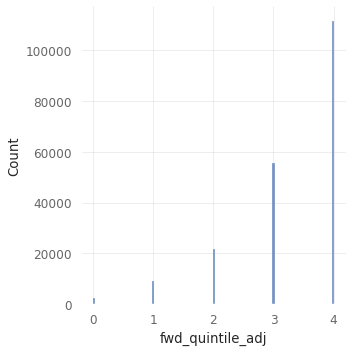

In [19]:
sns.displot(monthly_stock_data['fwd_quintile_adj'])

In [20]:

from sklearn.utils import class_weight

class_weights= class_weight.compute_class_weight('balanced', np.unique(monthly_stock_data['fwd_quintile_adj'].values), monthly_stock_data['fwd_quintile_adj'])
class_weights_dict  ={0:class_weights[0],1:class_weights[1],2:class_weights[2],3:class_weights[3],4:class_weights[4]}
class_weights_dict

/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=date
1986-04    3
1986-05    3
1986-06    2
1986-07    2
1986-08    2
          ..
2020-06    4
2020-07    4
2020-08    4
2020-09    4
2020-10    4
Name: fwd_quintile_adj, Length: 200393, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 17.68693733451015,
 1: 4.343151278716949,
 2: 1.85781300699949,
 3: 0.7196215032139908,
 4: 0.359024294109216}

# Prediction Config 

In [230]:
final_stock_data_prop = pivot_table_stocks_total.copy(deep=True).sort_values(by='date', ascending=False)
final_factor_data_prop = monthly_factors_adj.copy(deep=True).sort_values(by='date', ascending=False)
final_macro_data_prop = macro_factors.copy(deep=True).sort_values(by='date', ascending=False)
test_data_factors_prop =  monthly_factors_adj.loc[(monthly_factors_adj.index>=('1977-01'))&(monthly_factors_adj.index<('2008-11'))].sort_values(by='date', ascending=False)
test_data_macro_prop = macro_factors.loc[(macro_factors.index>=('1977-01'))&(macro_factors.index<('2008-11'))].sort_values(by='date', ascending=False)


final_stock_data = pivot_table_stocks.copy(deep=True)
final_factor_data = monthly_factors_adj.copy(deep=True)
final_macro_data = macro_factors.copy(deep=True)

batch_size_prop = 1
batch_size = 4
n_factors = len(final_factor_data.columns)
patience_value = 400

start_date = ('1977-01')
end_date = ('2020-10')
Y_name = 'fwd_quintile_adj'


label_names = np.sort(monthly_stock_data[Y_name].unique())
label_names

array([0, 1, 2, 3, 4])

# Neural Network Model Construction

Saving all model processes in a file to continue training the model with previous weights 

### local savings version

In [22]:
path_alternative = 'checkpoints_alternative/'

path_multi_target_merged_prop = path_alternative + 'path_multi_target_merged_prop.h5'
path_multi_target_factors_prop = path_alternative + 'path_multi_target_factors_prop.h5'


checkpoints_LSTM_model_merged_1L_alternative = path_alternative+'checkpoints_LSTM_model_merged_1L_alternative.h5'
checkpoints_LSTM_model_merged_2L_alternative = path_alternative+'checkpoints_LSTM_model_merged_2L_alternative.h5'
checkpoints_LSTM_model_merged_3L_alternative = path_alternative+'checkpoints_LSTM_model_merged_3L_alternative.h5'
checkpoints_LSTM_model_merged_4L_alternative = path_alternative+'checkpoints_LSTM_model_merged_4L_alternative.h5'

checkpoints_LSTM_model_1L_alternative = path_alternative+'checkpoints_LSTM_model_1L_alternative.h5'
checkpoints_LSTM_model_2L_alternative = path_alternative+'checkpoints_LSTM_model_2L_alternative.h5'
checkpoints_LSTM_model_3L_alternative = path_alternative+'checkpoints_LSTM_model_3L_alternative.h5'
checkpoints_LSTM_model_4L_alternative = path_alternative+'checkpoints_LSTM_model_4L_alternative.h5'

checkpoints_FFN_model_L1_alternative = path_alternative+'checkpoints_FFN_model_L1_alternative.h5'
checkpoints_FFN_model_L2_alternative = path_alternative+'checkpoints_FFN_model_L2_alternative.h5'
checkpoints_FFN_model_L3_alternative = path_alternative+'checkpoints_FFN_model_L3_alternative.h5'
checkpoints_FFN_model_L4_alternative = path_alternative+'checkpoints_FFN_model_L4_alternative.h5'

checkpoints_model_merged_1L_alternative = path_alternative+'checkpoints_model_merged_1L_alternative.h5'
checkpoints_model_merged_2L_alternative = path_alternative+'checkpoints_model_merged_2L_alternative.h5'
checkpoints_model_merged_3L_alternative = path_alternative+'checkpoints_model_merged_3L_alternative.h5'
checkpoints_model_merged_4L_alternative = path_alternative+'checkpoints_model_merged_4L_alternative.h5'

checkpoints_model_1L_alternative = path_alternative+'checkpoints_model_1L_alternative.h5'
checkpoints_model_2L_alternative = path_alternative+'checkpoints_model_2L_alternative.h5'
checkpoints_model_3L_alternative = path_alternative+'checkpoints_model_3L_alternative.h5'
checkpoints_model_4L_alternative = path_alternative+'checkpoints_model_4L_alternative.h5'


number_of_factors = final_factor_data.shape[1]
number_of_macro_factors = final_macro_data.shape[1] 
number_of_merged_factors = number_of_factors+number_of_macro_factors 

print('The dataset has: ', \
     number_of_factors, 'Smart-beta factors, ', \
     number_of_macro_factors, 'Macro factors, ', 'and',
     number_of_merged_factors, 'Total factors, ')

The dataset has:  33 Smart-beta factors,  136 Macro factors,  and 169 Total factors, 


# Data Creation: Tensor Generation

In [23]:
def batch_generator_backwards_data(stock_data,macro_data, factor_data, test_data_factors, test_data_macro, batch_size_prop):
    """
    model = NN model, 
    data = stock data, factor data, macro data,
    batch_size = timesteps per batch
    alpha adam = learning rate optimizer
    data set ratios = train_set_ratio, val_set_ratio (eg. 0.5)
    """
    

#
    train_date_index = stock_data.index.unique().tolist() 
    #train data
    train_data_factors = factor_data.loc[factor_data.index.isin(train_date_index)]
    train_data_macro = macro_data.loc[macro_data.index.isin(train_date_index)]
    train_data_macro_norm = train_data_macro.copy(deep=True)
    
    for c in train_data_macro_norm.columns: 
        train_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(train_data_macro_norm[c]))

    train_data_merged = pd.concat([train_data_factors, train_data_macro_norm],axis=1)
    
    
     #train data

    
    test_data_macro_norm = test_data_macro.copy(deep=True)
    
    for c in test_data_macro_norm.columns: 
        test_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(test_data_macro_norm[c]))

    test_data_merged = pd.concat([test_data_factors, test_data_macro_norm],axis=1)
    

    x_train_factors = []
    x_train_macro = []
    x_train_merged =[]
    y_train =[]

   
    for i in tqdm(range(batch_size_prop, len(stock_data))):
        x_train_factors.append(train_data_factors.values[i-batch_size_prop:i,:])
        x_train_macro.append(train_data_macro_norm.values[i-batch_size_prop:i,:])
        x_train_merged.append(train_data_merged.values[i-batch_size_prop:i,:])
        y_train.append(stock_data.values[i, :])   #

    x_train_factors, x_train_macro, x_train_merged, y_train= np.array(x_train_factors),np.array(x_train_macro),np.array(x_train_merged), np.array(y_train)
    
    
    x_test_factors = []
    x_test_macro =[]
    x_test_merged =[]
    
    for i in tqdm(range(batch_size_prop, len(test_data_macro_norm))):
        x_test_factors.append(test_data_factors.values[i-batch_size_prop:i,:])
        x_test_macro.append(test_data_macro_norm.values[i-batch_size_prop:i,:])
        x_test_merged.append(test_data_merged.values[i-batch_size_prop:i,:])  
        
        
    x_test_factors, x_test_macro, x_test_merged = np.array(x_test_factors), np.array(x_test_macro), np.array(x_test_merged)
    
    return x_train_factors, x_train_macro,x_train_merged,y_train , x_test_factors, x_test_macro, x_test_merged

In [24]:
x_train_factors_prop, x_train_macro_prop,x_train_merged_prop,y_train_prop, x_test_factors_prop, x_test_macro_prop, x_test_merged_prop = batch_generator_backwards_data(final_stock_data_prop,final_macro_data_prop, final_factor_data_prop,test_data_factors_prop, test_data_macro_prop, batch_size_prop)

100%|██████████| 375/375 [00:00<00:00, 80912.80it/s]


## Running backward prediction to get quintiles of stocks that do not have the length of 522

In [25]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.models import Model, Sequential   
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 

sgd = SGD(learning_rate=0.01, decay=1e-3/10, momentum=0.9, nesterov=True)
sgd_empty =SGD() 
adam = Adam(0.001)
rmsprop = RMSprop(0.0015)

config_prop = {'LOSS':[tf.keras.losses.MeanSquaredError()],             
          'METRICS':[tf.keras.metrics.MeanSquaredError()],    
         'OPTIMIZER':adam}  #specify learnig rate after having found optimal value                     #tf.keras.losses.MeanSquaredError() 

2022-08-28 16:03:05.157230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-28 16:03:05.157265: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-28 16:03:05.157289: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sagemaker-data-scie-ml-m5d-2xlarge-4b6d3b0a4abc36c03b0ba25d3988): /proc/driver/nvidia/version does not exist
2022-08-28 16:03:05.157512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential   
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 

LSTM_model_merged_3L_fillna = Sequential([layers.Input(shape=(batch_size_prop,number_of_merged_factors)),
                                   layers.LayerNormalization(),
                                   layers.LSTM(128, return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(64, return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(32, return_sequences =False),
                                   layers.LayerNormalization(),
                                   layers.Dense(16,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)), 
                                   layers.Dense(501,activation='leaky_relu')],name='LSTM_model_merged_fillna_3L')

LSTM_model_merged_3L_fillna.compile(loss=config_prop['LOSS'],optimizer=config_prop['OPTIMIZER'],metrics=config_prop['METRICS'])
LSTM_model_merged_3L_fillna.save(path_multi_target_merged_prop)
LSTM_model_merged_3L_fillna.summary()

LSTM_model_3L_fillna = Sequential([layers.Input(shape=(batch_size_prop,number_of_factors)),
                            layers.LayerNormalization(),
                            layers.LSTM(64,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(32,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(32, return_sequences =False),       
                            layers.LayerNormalization(),
                            layers.Dense(16, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
                            layers.Dense(501,activation='leaky_relu')],name='LSTM_model_factors_fillna_3L')

LSTM_model_3L_fillna.compile(loss=config_prop['LOSS'],optimizer=config_prop['OPTIMIZER'],metrics=config_prop['METRICS'])
LSTM_model_3L_fillna.save(path_multi_target_factors_prop)
LSTM_model_3L_fillna.summary()

Model: "LSTM_model_merged_fillna_3L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_12 (Lay  (None, 1, 169)           338       
 erNormalization)                                                
                                                                 
 lstm_35 (LSTM)              (None, 1, 128)            152576    
                                                                 
 layer_normalization_13 (Lay  (None, 1, 128)           256       
 erNormalization)                                                
                                                                 
 lstm_36 (LSTM)              (None, 1, 64)             49408     
                                                                 
 layer_normalization_14 (Lay  (None, 1, 64)            128       
 erNormalization)                                                
                                       

In [27]:
def backwards_prop(model_type,checkpoint_path, x_train_factors,x_train_merged,y_train, x_test_factors, x_test_merged, batch_size_prop, num_epochs, class_weights_dict):
    """
    model = NN model, 
    data = stock data, factor data, macro data,
    batch_size = timesteps per batch
    alpha adam = learning rate optimizer
    data set ratios = train_set_ratio, val_set_ratio (eg. 0.5)
    """
    import tensorflow as tf
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_squared_error',                   #'loss'  #val_mean_squared_error
        patience=2000,
        mode='min')
    
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor= 'val_mean_squared_error',
        verbose=False,
        save_best_only=True,
        save_freq = 'epoch',
        mode='min')

    trained_model = tf.keras.models.load_model(checkpoint_path)
    
    if model_type=='merged':


        trained_model.fit(x=x_train_merged, y=y_train,batch_size=batch_size_prop, epochs=num_epochs,class_weight=class_weights_dict,
                          validation_split=0.09, callbacks=[cp_callback, early_stopping], verbose=1)  # 
        
        model_score = trained_model.evaluate(x_train_merged, y_train, batch_size_prop)
        predictions = trained_model.predict(x_test_merged, batch_size_prop)
        
    if model_type=='factors':

        trained_model.fit(x=x_train_factors,y=y_train,batch_size=batch_size_prop, epochs=num_epochs,class_weight=class_weights_dict,
                          validation_split=0.09, callbacks=[cp_callback, early_stopping], verbose=1)
        
        model_score = trained_model.evaluate(x_train_factors, y_train,batch_size_prop)
        
        predictions = trained_model.predict(x_test_factors, batch_size_prop)
    return predictions, model_score

## Predicting backward quintiles

In [40]:
predictions_factors, score_prop_factors = backwards_prop('factors', path_multi_target_factors_prop ,x_train_factors_prop,x_train_merged_prop,y_train_prop, x_test_factors_prop, x_test_merged_prop, batch_size_prop, 10000, class_weights_dict)

predictions_merged,score_prop_merged  = backwards_prop('merged', path_multi_target_merged_prop,x_train_factors_prop,x_train_merged_prop,y_train_prop, x_test_factors_prop, x_test_merged_prop, batch_size_prop, 10000, class_weights_dict)

97/97 [==============================] - 0s 4ms/step - loss: 0.1167 - mean_squared_error: 0.0383 - val_loss: 0.2883 - val_mean_squared_error: 0.2820
Epoch 4722/10000
97/97 [==============================] - 0s 4ms/step - loss: 0.1189 - mean_squared_error: 0.0390 - val_loss: 0.2974 - val_mean_squared_error: 0.2907
Epoch 4723/10000
97/97 [==============================] - 0s 4ms/step - loss: 0.1216 - mean_squared_error: 0.0398 - val_loss: 0.2874 - val_mean_squared_error: 0.2805
Epoch 4724/10000
97/97 [==============================] - 0s 4ms/step - loss: 0.1193 - mean_squared_error: 0.0392 - val_loss: 0.2881 - val_mean_squared_error: 0.2811
Epoch 4725/10000
97/97 [==============================] - 0s 4ms/step - loss: 0.1201 - mean_squared_error: 0.0395 - val_loss: 0.2918 - val_mean_squared_error: 0.2850
Epoch 4726/10000
97/97 [==============================] - 0s 4ms/step - loss: 0.1175 - mean_squared_error: 0.0386 - val_loss: 0.2896 - val_mean_squared_error: 0.2830
Epoch 4727/10000
97/9

### The LSTM merged model achieved a val MSE of 0.26 to predict backwards quintiles, the factor model 0.8

In [45]:
y_train_prop.max()

4.0

In [57]:
predictions_factors = pd.DataFrame(predictions_factors)
predictions_merged = pd.DataFrame(predictions_merged)

predictions_factors.to_csv('predictions_factors_back_prop_NN.csv')
file_saver('predictions_factors_back_prop_NN.csv','predictions_factors_back_prop_NN.csv')

predictions_merged.to_csv('predictions_merged_back_prop_NN.csv')
file_saver('predictions_merged_back_prop_NN.csv','predictions_merged_back_prop_NN.csv')

print('save prop scores ')
np.savez_compressed('prop_model_scores.npz', score_prop_factors=score_prop_factors, score_prop_merged=score_prop_factors)
                    
file_saver('prop_model_scores.npz','prop_model_scores.npz')

save prop scores 


In [58]:
print(score_prop_factors)
print(score_prop_merged)

# [0.12568454444408417, 0.11696605384349823]
# [0.0667126253247261, 0.060485225170850754

[0.12568454444408417, 0.11696605384349823]
[0.0667126253247261, 0.060485225170850754]


In [72]:
predictions_merged.round().values.max()

5.0

In [96]:
pivot_table_stocks.loc[pivot_table_stocks.index==('1986-03')]

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
1986-03,NaN,NaN,NaN,4.0,3.0,NaN,NaN,4.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [107]:
test_data_factors_prop.index[1:]

Index(['2008-09', '2008-08', '2008-07', '2008-06', '2008-05', '2008-04',
       '2008-03', '2008-02', '2008-01', '2007-12',
       ...
       '1978-04', '1978-03', '1978-02', '1978-01', '1977-12', '1977-11',
       '1977-10', '1977-09', '1977-08', '1977-07'],
      dtype='object', name='date', length=375)

In [99]:
uncomplete_df = pivot_table_stocks.copy()
uncomplete_df = uncomplete_df.loc[(uncomplete_df.index>=('1977-01'))&(uncomplete_df.index<=('2008-09'))]
uncomplete_df = uncomplete_df.sort_values(by='date', ascending=False)
uncomplete_df

predictions_factors = pd.DataFrame(predictions_factors)
predictions_factors.index = test_data_factors_prop.index[1:]
predictions_factors.columns = pivot_table_stocks.columns
predictions_factors = predictions_factors.round().sort_values(by='date',ascending=False)
predictions_factors

predictions_merged = pd.DataFrame(predictions_merged)
predictions_merged.index = test_data_factors_prop.index[1:]
predictions_merged.columns = pivot_table_stocks.columns
predictions_merged = predictions_merged.round().sort_values(by='date',ascending=False)
predictions_merged

def value_propagation(df, df_prop):
    altered_df = df.copy()
    for i in df.columns:
        if any(df[i].isna()): 
            
            isna_index = df.loc[pd.isna(df[i]), :].index.values
            altered_df.loc[isna_index,i] = df_prop.loc[isna_index, i].values

    return altered_df

complete_stock_quintiles_factors = value_propagation(uncomplete_df, predictions_factors)
complete_stock_quintiles_factors = complete_stock_quintiles_factors.sort_values(by='date')
complete_stock_quintiles_factors

complete_stock_quintiles_merged = value_propagation(uncomplete_df, predictions_merged)
complete_stock_quintiles_merged = complete_stock_quintiles_merged.sort_values(by='date')
complete_stock_quintiles_merged

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
1977-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-09,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-10,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-11,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-05,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,3.0,...,2.0,3.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2008-06,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,3.0,...,2.0,3.0,3.0,3.0,1.0,3.0,4.0,4.0,2.0,3.0
2008-07,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,2.0,3.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0


In [108]:
pivot_table_stocks.dropna().sort_values(by='date')

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
2008-11,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,2.0,3.0,3.0,3.0,2.0,3.0,4.0,4.0,3.0,3.0
2008-12,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,3.0,4.0,2.0,1.0,3.0,4.0,4.0,3.0,4.0
2009-01,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,2.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2009-02,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,4.0,...,1.0,2.0,4.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2009-03,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,1.0,3.0,4.0,3.0,2.0,3.0,4.0,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0


In [109]:
uncomplete_df

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
2008-09,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,2.0,3.0,3.0,2.0,1.0,3.0,4.0,4.0,3.0,3.0
2008-08,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,2.0,3.0,3.0,2.0,2.0,3.0,4.0,4.0,3.0,3.0
2008-07,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,4.0,...,2.0,3.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
2008-06,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,3.0,...,2.0,3.0,3.0,3.0,1.0,3.0,4.0,4.0,2.0,3.0
2008-05,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,1.0,3.0,...,2.0,3.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977-11,NaN,NaN,NaN,4.0,3.0,NaN,NaN,4.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977-10,NaN,NaN,NaN,4.0,3.0,NaN,NaN,4.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977-09,NaN,NaN,NaN,4.0,3.0,NaN,NaN,4.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
to_merge = pivot_table_stocks.loc[pivot_table_stocks.index>=('2008-10')]
complete_stock_quintiles = pd.concat([complete_stock_quintiles_merged, to_merge],axis=0)
complete_stock_quintiles = complete_stock_quintiles.apply(lambda x: x.fillna(x.mean(),axis=0))
complete_stock_quintiles = complete_stock_quintiles.dropna()
complete_stock_quintiles

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
1977-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-09,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-10,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-11,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0


### To avoid model false fitting we replace all values above 5 with 4 

In [116]:
print(complete_stock_quintiles.values.max())
print(complete_stock_quintiles.values.min())

5.0
0.0


In [117]:
complete_stock_quintiles = complete_stock_quintiles.replace(5,4)
complete_stock_quintiles.values.max()

4.0

In [118]:
complete_stock_quintiles.to_csv('complete_stock_quintiles_NN_pred.csv')
file_saver('complete_stock_quintiles_NN_pred.csv','complete_stock_quintiles_NN_pred.csv')

complete_stock_quintiles_factors.to_csv('complete_stock_quintiles_factors_NN.csv')
file_saver('complete_stock_quintiles_factors_NN.csv','complete_stock_quintiles_factors_NN.csv')

complete_stock_quintiles_merged.to_csv('complete_stock_quintiles_merged_NN.csv')
file_saver('complete_stock_quintiles_merged_NN.csv','complete_stock_quintiles_merged_NN.csv')

In [119]:
complete_stock_quintiles_merged = pd.read_csv(path_bucket+'complete_stock_quintiles_NN_pred.csv', index_col=0)
complete_stock_quintiles_merged = complete_stock_quintiles_merged.astype(float)
complete_stock_quintiles_merged.values.max()

4.0

In [120]:
def batch_generator_complete_data(stock_data,macro_data, factor_data, batch_size, train_set_ratio):
    """
    model = NN model, 
    data = stock data, factor data, macro data,
    batch_size = timesteps per batch
    alpha adam = learning rate optimizer
    data set ratios = train_set_ratio, val_set_ratio (eg. 0.5)
    """

    
    train_stock_data = stock_data.iloc[0:int(len(stock_data)*train_set_ratio),:]
    test_stock_data = stock_data.iloc[int(len(stock_data)*(train_set_ratio)):,:]
        
    train_date_index = train_stock_data.index.unique().tolist() 
    test_date_index = test_stock_data.index.unique().tolist()

        
    #train data
    train_data_factors = factor_data.loc[factor_data.index.isin(train_date_index)]
    train_data_macro = macro_data.loc[macro_data.index.isin(train_date_index)]
    train_data_macro_norm = train_data_macro.copy(deep=True)
    
    for c in train_data_macro_norm.columns: 
        train_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(train_data_macro_norm[c]))

    train_data_merged = pd.concat([train_data_factors, train_data_macro_norm],axis=1)
    
    test_data_factors = factor_data.loc[factor_data.index.isin(test_date_index)]
    test_data_macro = macro_data.loc[macro_data.index.isin(test_date_index)]
    test_data_macro_norm = test_data_macro.copy(deep=True)
    
    for c in test_data_macro_norm.columns: 
        test_data_macro_norm[c] = MinMaxScaler([-1,1]).fit_transform(pd.DataFrame(test_data_macro_norm[c]))

    test_data_merged = pd.concat([test_data_factors, test_data_macro_norm],axis=1)
    

    x_train_factors = []
    x_train_macro = []
    x_train_merged =[]
    y_train =[]

    for i in tqdm(range(batch_size, len(train_data_factors))):
        x_train_factors.append(train_data_factors.values[i-batch_size:i,:])
        x_train_macro.append(train_data_macro_norm.values[i-batch_size:i,:])
        x_train_merged.append(train_data_merged.values[i-batch_size:i,:])
        y_train.append(train_stock_data.values[i,:])   #

    x_train_factors, x_train_macro, x_train_merged, y_train= np.array(x_train_factors),np.array(x_train_macro),np.array(x_train_merged), np.array(y_train)


    x_test_factors = []
    x_test_macro = []
    x_test_merged =[]
    x_test_merged = []
    y_test = []

    for i in tqdm(range(batch_size, len(test_data_factors))):
        x_test_factors.append(test_data_factors.values[i-batch_size:i,:])
        x_test_macro.append(test_data_macro_norm.values[i-batch_size:i,:])
        x_test_merged.append(test_data_merged.values[i-batch_size:i,:])
        y_test.append(test_stock_data.values[i,:])

    x_test_factors, x_test_macro,x_test_merged, y_test = np.array(x_test_factors), np.array(x_test_macro),np.array(x_test_merged), np.array(y_test)


    return x_train_factors, x_train_macro,x_train_merged,y_train,x_test_factors,x_test_macro,x_test_merged, y_test

In [121]:
x_train_factors, x_train_macro,x_train_merged,y_train,x_test_factors,x_test_macro,x_test_merged, y_test = batch_generator_complete_data(complete_stock_quintiles,final_macro_data, final_factor_data, batch_size, 0.8)

100%|██████████| 100/100 [00:00<00:00, 51787.92it/s]


In [122]:
complete_stock_quintiles.dropna().shape

(520, 501)

In [123]:
y_test.shape
x_test_merged.shape

(100, 4, 169)

In [124]:
print(x_train_factors.shape)
print(y_train.shape)
print(x_test_factors.shape)
print(y_test.shape)

(412, 4, 33)
(412, 501)
(100, 4, 33)
(100, 501)


In [125]:
print('save train data')
np.savez_compressed('train_arrays_multi_available.npz',x_train_factors=x_train_factors,x_train_macro=x_train_macro,x_train_merged=x_train_merged,y_train=y_train)

print('save test data')
np.savez_compressed('test_arrays_multi_available.npz',x_test_factors=x_test_factors,x_test_macro=x_test_macro,x_test_merged=x_test_merged, y_test=y_test)

save train data
save test data


In [126]:
len(final_stock_data.index.unique())
final_stock_data.index.min()

'1977-07'

In [127]:
file_saver('train_arrays_multi_available.npz','train_arrays_multi_available.npz')
file_saver('test_arrays_multi_available.npz','test_arrays_multi_available.npz')

## Load in the Data

## Data for complete data set 

In [128]:
train_array = np.load('train_arrays_multi_available.npz', allow_pickle=True)
x_train_factors = train_array['x_train_factors']
x_train_macro = train_array['x_train_macro']
x_train_merged = train_array['x_train_merged']
y_train = train_array['y_train']


In [129]:
x_train_factors.shape
x_train_macro.shape
x_train_merged.shape

(412, 4, 169)

## Non loop model

In [150]:
def compile_and_fit_simple(model_type,checkpoint_path,config,stock_data, x_train_factors,x_train_macro,x_train_merged,y_train, patience, batch_size, num_epochs, goal,class_weights_dict):
    """
    model = NN model, 
    data = stock data, factor data, macro data,
    batch_size = timesteps per batch
    alpha adam = learning rate optimizer
    data set ratios = train_set_ratio, val_set_ratio (eg. 0.5)
    """
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', #val_mean_squared_error                  #'loss'  #val_mean_squared_error
        patience=patience,
        mode='min')
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor= 'val_loss',
        verbose=False,
        save_best_only=True,
        save_freq = 'epoch',
        mode='min')
    
    scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-04*10**(epoch/10))
    
    trained_model = tf.keras.models.load_model(checkpoint_path)

    
    if goal=='lr':
        if model_type=='combined':
             
                
            history = trained_model.fit(x=[x_train_macro,x_train_factors],y=y_train,batch_size=batch_size, epochs=20,
                              validation_split=0.09, callbacks=[scheduler]) #

        if model_type=='merged':


            history = trained_model.fit(x=x_train_merged, y=y_train,batch_size=batch_size, epochs=20,
                              validation_split=0.09, callbacks=[scheduler])  # 
        if model_type=='factors':

            history =  trained_model.fit(x=x_train_factors,y=y_train,batch_size=batch_size, epochs=20,
                              validation_split=0.09, callbacks=[scheduler])             

        return trained_model 
    if goal=='fit':
        if model_type=='combined':

            history = trained_model.fit(x=[x_train_macro,x_train_factors],y=y_train,batch_size=batch_size, epochs=num_epochs,
                              validation_split=0.09, callbacks=[early_stopping,cp_callback]) #
            
            score = trained_model.evaluate([x_train_macro, x_train_factors], y_train, batch_size)
            
        if model_type=='merged':


            history = trained_model.fit(x=x_train_merged, y=y_train,batch_size=batch_size, epochs=num_epochs,
                              validation_split=0.09, callbacks=[early_stopping,cp_callback])  # 
            
            score = trained_model.evaluate(x_train_merged, y_train, batch_size)
        if model_type=='factors':

            history = trained_model.fit(x=x_train_factors,y=y_train,batch_size=batch_size, epochs=num_epochs,
                              validation_split=0.09, callbacks=[early_stopping,cp_callback])             

            score = trained_model.evaluate(x_train_factors, y_train, batch_size)
        
        trained_model.save(checkpoint_path[:-3]+'_final'+ '.h5')
        
    return history, score                        

In [144]:
def get_test_data_stocks(stock_data,batch_size,train_set_ratio):
    
    pivot_stock_data = stock_data.iloc[int(len(stock_data)*(train_set_ratio)):,:]
    pivot_stock_data = pivot_stock_data.iloc[batch_size:,:] 
    pivot_stock_data = pivot_stock_data+1
    test_stock_data_df = pivot_stock_data.reset_index().melt(id_vars=['date'])
    test_stock_data_df = test_stock_data_df.sort_values(by=['date','permno'])
    return pivot_stock_data, test_stock_data_df 

In [367]:
import tensorflow as tf

def nn_predict_simple(model_type,test_data_stocks, test_factors,test_macro,test_merged, model_path, batch_size, label_names):
    permnos = test_data_stocks.columns.unique()
    permno_df =test_data_stocks.copy()
    
    trained_model = tf.keras.models.load_model(model_path) 
    
    if model_type =='combined':
        predictions = trained_model.predict([test_macro, test_factors],batch_size)
        predictions_pivot = pd.DataFrame(index=test_data_stocks.index, columns=test_data_stocks.columns)
        predictions_pivot.iloc[:,:] =  predictions
 
    elif model_type =='factors':
        predictions = trained_model.predict(test_factors,batch_size)
        predictions_pivot = pd.DataFrame(index=test_data_stocks.index, columns=test_data_stocks.columns)
        predictions_pivot.iloc[:,:] =  predictions
    
    elif model_type =='merged':
        predictions = trained_model.predict(test_merged,batch_size)
        predictions_pivot = pd.DataFrame(index=test_data_stocks.index, columns=test_data_stocks.columns)
        predictions_pivot.iloc[:,:] =  predictions
    
    predictions_pivot = predictions_pivot.astype(float)
    predictions_pivot = predictions_pivot.round()
    predictions_pivot = predictions_pivot+1
    predictions_df = predictions_pivot.copy()
    predictions_df = predictions_df.astype(float)
    predictions_df =  predictions_df.reset_index().melt(id_vars=['date'])
    predictions_df = predictions_df.sort_values(by=['date', 'permno'])

    return predictions_pivot, predictions_df, predictions

In [146]:
def r2_oos(true_values, pred_values):
    r2 = 1 - ((sum((true_values-pred_values)**2))/(sum(true_values**2)))
    return r2 


def create_metrics(test_data_df, prediction_df, batch_size, n_factors, r2_oos,dataframe_name):
    prediction_df = prediction_df.copy()
    pred_name = prediction_df.columns.tolist()
    pred_name = pred_name[2]
    
    comparison = pd.merge(test_data_df, prediction_df, how='left', on=['date', 'permno'])
    comparison = comparison.rename(columns={'value_x':'true quint', 'value_y':'pred quint'})
    r2= r2_score(comparison.iloc[:,2],comparison.iloc[:,3])
    r2_oos = r2_oos(comparison.iloc[:,2],comparison.iloc[:,3])
    
    r2_adj = 1-(1-r2)*(len(comparison.iloc[:,3])-1)/((len(comparison.iloc[:,3])-n_factors-1))
    r2_adj_oos = 1-(1-r2_oos)*(len(comparison.iloc[:,3])-1)/((len(comparison.iloc[:,3])-n_factors-1))
    MSE = mean_squared_error(comparison.iloc[:,2],comparison.iloc[:,3])
    rss = np.sum((comparison.iloc[:,3]-comparison.iloc[:,2])**2)

    df_metrics =  pd.DataFrame(data=[r2,r2_oos,r2_adj,r2_adj_oos, MSE, rss])
    df_metrics=df_metrics.rename(index={0:'r2',1:'r2_oos', 2:'r2_adj', 3:'r2_adj_oos',4:'MSE',5:'rss'},columns={0:dataframe_name})
    return comparison, df_metrics

In [147]:
def model_metrics(model, x, y, y_pred, sample_weights=1):
    compute_loss = model.compute_loss(x,y,y_pred, sample_weights)
    
    compute_metrics = model.compute_metrics(x,y,y_pred, sample_weights)
    
    evaluated_model = model.evaluate(x,y,batch_size=32)
    
    return compute_loss, compute_metrics, evaluated_model

def sharpe(r):
    return (np.nanmean(r)/np.nanstd(r))  

# Neural network models 

In [149]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.models import Model, Sequential   
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 

sgd = SGD(learning_rate=0.01, decay=1e-3/10, momentum=0.9, nesterov=True)
sgd_empty =SGD() 
adam = Adam(0.001)
rmsprop = RMSprop(0.0015)

config = {'LOSS':[tf.keras.losses.MeanSquaredError()],             
          'METRICS':[tf.keras.metrics.MeanSquaredError()],    
         'OPTIMIZER':adam} 

## Merged Feedforward neural networks

In [151]:
x_train_merged.shape

(412, 4, 169)

In [211]:
model_merged_1L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                              layers.Dense(128, activation='leaky_relu' , kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                              layers.Dropout(0.4),
                              layers.Flatten(),
                              layers.Dense(501,activation='leaky_relu')],name = 'model_merged_datasets_1L') 

model_merged_1L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
# model_merged_1L.save(checkpoints_model_merged_1L_alternative)
model_merged_1L.summary()

model_merged_2L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                                   layers.Dense(128 ,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                                   layers.Dropout(0.2),
                                   layers.Dense(64,activation='leaky_relu'),
                                   layers.Dropout(0.2),
                                   layers.Flatten(),
                                   layers.Dense(501,activation='leaky_relu')],name='model_merged_datasets_2L')

model_merged_2L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
# model_merged_2L.save(checkpoints_model_merged_2L_alternative)
model_merged_2L.summary()

model_merged_3L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                             layers.Dense(128,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                             layers.Dropout(0.2),
                             layers.Dense(64,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                             layers.Dropout(0.2),
                             layers.Dense(32,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                             layers.Dropout(0.2),
                             layers.Flatten(),
                             layers.Dense(501, activation='leaky_relu')],name='model_merged_datasets_3L')

model_merged_3L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
# model_merged_3L.save(checkpoints_model_merged_3L_alternative)
model_merged_3L.summary()

model_merged_4L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                              layers.Dense(128,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                              layers.Dropout(0.2),
                              layers.Dense(64,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                              layers.Dropout(0.2),
                              layers.Dense(32,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                              layers.Dropout(0.2),
                              layers.Dense(16,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                              layers.Dropout(0.2),
                              layers.Flatten(),
                              layers.Dense(501,activation='leaky_relu' )],name='model_merged_datasets_4L')

model_merged_4L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
# model_merged_4L.save(checkpoints_model_merged_4L_alternative)
model_merged_4L.summary()

Model: "model_merged_datasets_1L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_376 (Dense)           (None, 4, 128)            21760     
                                                                 
 dropout_167 (Dropout)       (None, 4, 128)            0         
                                                                 
 flatten_64 (Flatten)        (None, 512)               0         
                                                                 
 dense_377 (Dense)           (None, 501)               257013    
                                                                 
Total params: 278,773
Trainable params: 278,773
Non-trainable params: 0
_________________________________________________________________
Model: "model_merged_datasets_2L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d

## Factor Only Feedforward models

In [212]:
from tensorflow.keras.models import Model, Sequential   
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 


model_input_macro = layers.Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = layers.Input(shape=(batch_size,number_of_factors))

#################################################### LSTM  models with only factor data ##################################################
model_1L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                         layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                         layers.Dropout(0.3),
                         layers.Flatten(),
                         layers.Dense(501,activation='leaky_relu')],name='model_factors_only_1L')

model_1L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
model_1L.save(checkpoints_model_1L_alternative)
model_1L.summary()

model_2L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                         layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                         layers.Dropout(0.2),
                         layers.Dense(16,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                         layers.Dropout(0.2),
                         layers.Flatten(),
                         layers.Dense(501,activation='leaky_relu')],name='model_factors_only_2L')

model_2L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
model_2L.save(checkpoints_model_2L_alternative)
model_2L.summary()

model_3L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                         layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                         layers.Dropout(0.2),
                         layers.Dense(16,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                         layers.Dropout(0.2),
                         layers.Dense(8, activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                         layers.Dropout(0.2),
                         layers.Flatten(),
                         layers.Dense(501,activation='leaky_relu')],name='model_factors_only_3L')

model_3L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
model_3L.save(checkpoints_model_3L_alternative)
model_3L.summary()

model_4L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                            layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                            layers.Dropout(0.2),
                            layers.Dense(16,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                            layers.Dropout(0.2),
                            layers.Dense(8,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                            layers.Dropout(0.2),
                            layers.Dense(8,activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                            layers.Dropout(0.2),
                            layers.Dropout(0.2),
                            layers.Flatten(),
                            layers.Dense(501,activation='leaky_relu')],name='model_factors_only_4L')

model_4L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
model_4L.save(checkpoints_model_4L_alternative)
model_4L.summary()

Model: "model_factors_only_1L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_390 (Dense)           (None, 4, 32)             1088      
                                                                 
 dropout_177 (Dropout)       (None, 4, 32)             0         
                                                                 
 flatten_68 (Flatten)        (None, 128)               0         
                                                                 
 dense_391 (Dense)           (None, 501)               64629     
                                                                 
Total params: 65,717
Trainable params: 65,717
Non-trainable params: 0
_________________________________________________________________
Model: "model_factors_only_2L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_392

## Simple LSTM neural network models:
* models using the merged dataset including factors and macro data 
* models using only factor data as input

In [213]:
config = {'LOSS':[tf.keras.losses.MeanSquaredError()],             
          'METRICS':[tf.keras.metrics.MeanSquaredError()],    
         'OPTIMIZER':adam}  #specify learnig rate after having found optimal value                     #tf.keras.losses.MeanSquaredError() 

### LSTM models with merged data set (macro & factors)

In [214]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 

LSTM_model_merged_1L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                                   layers.LayerNormalization(),
                                   layers.LSTM(128,  return_sequences =False),
                                   layers.Dense(64, activation='leaky_relu',kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                                   layers.LayerNormalization(),
                                   layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                                   layers.Dense(501,activation='leaky_relu')],name = 'LSTM_model_merged_datasets_1L') 

LSTM_model_merged_1L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_merged_1L.save(checkpoints_LSTM_model_merged_1L_alternative)
LSTM_model_merged_1L.summary()

LSTM_model_merged_2L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                                   layers.LayerNormalization(),
                                   layers.LSTM(128, return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(64, return_sequences =False),
                                   layers.LayerNormalization(),
                                   layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)), 
                                   layers.Dense(501,activation='leaky_relu')],name='LSTM_model_merged_datasets_2L')

LSTM_model_merged_2L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_merged_2L.save(checkpoints_LSTM_model_merged_2L_alternative)
LSTM_model_merged_2L.summary()

LSTM_model_merged_3L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                                   layers.LayerNormalization(),
                                   layers.LSTM(128,  return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(64,  return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(32,  return_sequences = False),
                                   layers.LayerNormalization(axis=1),
                                   layers.Dense(16,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                                   layers.Dense(501, activation='leaky_relu')],name='LSTM_model_merged_datasets_3L')

LSTM_model_merged_3L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_merged_3L.save(checkpoints_LSTM_model_merged_3L_alternative)
LSTM_model_merged_3L.summary()

LSTM_model_merged_4L = Sequential([layers.Input(shape=(batch_size,number_of_merged_factors)),
                                   layers.LSTM(128, return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(64,  return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(32,  return_sequences =True),
                                   layers.LayerNormalization(),
                                   layers.LSTM(16,  return_sequences = False),
                                   layers.LayerNormalization(),
                                   layers.Dense(8,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                                   layers.Dense(501,activation='leaky_relu' )],name='LSTM_model_merged_datasets_4L')

LSTM_model_merged_4L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_merged_4L.save(checkpoints_LSTM_model_merged_4L_alternative)
LSTM_model_merged_4L.summary()

Model: "LSTM_model_merged_datasets_1L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_227 (La  (None, 4, 169)           338       
 yerNormalization)                                               
                                                                 
 lstm_240 (LSTM)             (None, 128)               152576    
                                                                 
 dense_404 (Dense)           (None, 64)                8256      
                                                                 
 layer_normalization_228 (La  (None, 64)               128       
 yerNormalization)                                               
                                                                 
 dense_405 (Dense)           (None, 32)                2080      
                                                                 
 dense_406 (Dense)           (None, 5

### LSTM models with only factor data

In [215]:
from tensorflow.keras.models import Model, Sequential   
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers 


model_input_macro = layers.Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = layers.Input(shape=(batch_size,number_of_factors))

#################################################### LSTM  models with only factor data ##################################################
LSTM_model_1L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                            layers.LayerNormalization(),
                            layers.LSTM(64, return_sequences =False),
                            layers.LayerNormalization(),
                            layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                            layers.Dense(501,activation='leaky_relu')],name='LSTM_model_factors_only_1L')

LSTM_model_1L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_1L.save(checkpoints_LSTM_model_1L_alternative)
LSTM_model_1L.summary()

LSTM_model_2L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                            layers.LayerNormalization(),
                            layers.LSTM(64,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(32,  return_sequences =False),
                            layers.LayerNormalization(),
                            layers.Dense(16, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                            layers.Dense(501,activation='leaky_relu')],name='LSTM_model_factors_only_2L')

LSTM_model_2L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_2L.save(checkpoints_LSTM_model_2L_alternative)
LSTM_model_2L.summary()

LSTM_model_3L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                            layers.LSTM(64,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(32,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(16,  return_sequences = False),
                            layers.LayerNormalization(),
                            layers.Dense(8, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                            layers.Dense(501,activation='leaky_relu')],name='LSTM_model_factors_only_3L')

LSTM_model_3L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_3L.save(checkpoints_LSTM_model_3L_alternative)
LSTM_model_3L.summary()

LSTM_model_4L = Sequential([layers.Input(shape=(batch_size,number_of_factors)),
                            layers.LSTM(64,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(32,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(32,  return_sequences =True),
                            layers.LayerNormalization(),
                            layers.LSTM(16,   return_sequences = False),
                            layers.LayerNormalization(),
                            layers.Dense(8,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005)),
                            layers.Dense(501,activation='leaky_relu')],name='LSTM_model_factors_only_4L')

LSTM_model_4L.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
LSTM_model_4L.save(checkpoints_LSTM_model_4L_alternative)
LSTM_model_4L.summary()

Model: "LSTM_model_factors_only_1L"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_240 (La  (None, 4, 33)            66        
 yerNormalization)                                               
                                                                 
 lstm_250 (LSTM)             (None, 64)                25088     
                                                                 
 layer_normalization_241 (La  (None, 64)               128       
 yerNormalization)                                               
                                                                 
 dense_413 (Dense)           (None, 32)                2080      
                                                                 
 dense_414 (Dense)           (None, 501)               16533     
                                                                 
Total params: 43,895
Trainable params: 4

### Combined models (LSTM transformed macro + LSTM FFN)

### One layer combined model

Adjust outputs:
* to 0 to get LSTM output that includes hidden states and transformes input
* to 1 to get LSTM hidden states h (only compatible with batch size = 1, activate expand dims layer function)


Model using another macro model to pass input

In [216]:
specs_one_layer_FFN = {'input_units_macro': 128, 'output_units':4, 'outputs':0, 'input_units_FFN_1L':32}

from tensorflow.keras import Input

model_input_macro = Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = Input(shape=(batch_size,number_of_factors))


#transform macro variables
x_macro_L1 = layers.LSTM(specs_one_layer_FFN['input_units_macro'], return_sequences =True, return_state=False)(model_input_macro)
normalize_1 = layers.LayerNormalization()(x_macro_L1)
regularize_1 = layers.Dense(64,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(normalize_1)
LSTM_model_macro_L1_output,LSTM_model_macro_L1_states_h, LSTM_model_macro_L1_states_c = layers.LSTM(specs_one_layer_FFN['output_units'],return_sequences=True, return_state=True)(regularize_1)

LSTM_model_macro_1L = Model(model_input_macro, (LSTM_model_macro_L1_output,LSTM_model_macro_L1_states_h), name='one-layer-macro-model')
macro_transformed_1L = LSTM_model_macro_1L(model_input_macro)[specs_one_layer_FFN['outputs']] 

# # macro_transformed_1L = tf.expand_dims(macro_transformed_1L, 1)
merged_layers_transformed_1L = layers.Concatenate()([model_input_factors,macro_transformed_1L])

#one layer LSTM network to predict returns
LSTM_comb_1L = layers.LSTM(specs_one_layer_FFN['input_units_FFN_1L'],  return_sequences =False, return_state=False)(merged_layers_transformed_1L)
normalize_2 = layers.LayerNormalization()(LSTM_comb_1L)
regularize_2 = layers.Dense(16,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001))(normalize_2)
returns_L1 = layers.Dense(501,activation='leaky_relu')(regularize_2)

FFN_model_L1 = Model(inputs=(model_input_macro,model_input_factors),outputs=returns_L1, name='one_layer_FFN_model')
# FFN_model_L1([macro_factors,monthly_factors])


FFN_model_L1.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
FFN_model_L1.save(checkpoints_FFN_model_L1_alternative)
FFN_model_L1.summary()

Model: "one_layer_FFN_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_197 (InputLayer)         [(None, 4, 136)]     0           []                               
                                                                                                  
 input_198 (InputLayer)         [(None, 4, 33)]      0           []                               
                                                                                                  
 one-layer-macro-model (Functio  ((None, 4, 4),      145296      ['input_197[0][0]']              
 nal)                            (None, 4))                                                       
                                                                                                  
 concatenate_17 (Concatenate)   (None, 4, 37)        0           ['input_198[0][

### Two layer combined model

Adjust outputs:
* to 0 to get LSTM output that includes hidden states and transformes input
* to 1 to get LSTM hidden states h (only compatible with batch size = 1, activate expand dims layer function)


In [217]:
specs_two_layer_FFN = {'input_units_macro_1L': 128,'input_units_macro_2L': 64, 'output_units':4, 'outputs':0,
                       'input_units_FFN_1L':32, 'input_units_FFN_2L':16}

from tensorflow.keras import Input

model_input_macro = Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = Input(shape=(batch_size,number_of_factors))

#transform macro variables
x_macro_L1 = layers.LSTM(specs_two_layer_FFN['input_units_macro_1L'],  return_sequences =True,  return_state=False)(model_input_macro)
normalize_1= layers.LayerNormalization()(x_macro_L1)
x_macro_L2 = layers.LSTM(specs_two_layer_FFN['input_units_macro_2L'], return_sequences =True,  return_state=False)(normalize_1)
normalize_2= layers.LayerNormalization()(x_macro_L2)
regularize_1 = layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(normalize_2)
LSTM_model_macro_L2_output,LSTM_model_macro_L2_states_h, LSTM_model_macro_L2_states_c = layers.LSTM(specs_two_layer_FFN['output_units'],return_sequences=True, return_state=True)(regularize_1)

LSTM_model_macro_2L = Model(model_input_macro, (LSTM_model_macro_L2_output,LSTM_model_macro_L2_states_h), name='two-layer-macro-model')
macro_transformed_2L = LSTM_model_macro_2L(model_input_macro)[specs_two_layer_FFN['outputs']] 

# macro_transformed_2L = tf.expand_dims(macro_transformed_2L, 1)
merged_layers_transformed_2L = layers.Concatenate()([model_input_factors,macro_transformed_2L])

# #one layer LSTM network to predict returns
LSTM_comb_1L = layers.LSTM(specs_two_layer_FFN['input_units_FFN_1L'],  return_sequences =True, return_state=False)(merged_layers_transformed_2L)
normalize_3= layers.LayerNormalization()(LSTM_comb_1L)
LSTM_comb_2L = layers.LSTM(specs_two_layer_FFN['input_units_FFN_2L'],  return_sequences =False,  return_state=False)(normalize_3)
normalize_4 = layers.LayerNormalization()(LSTM_comb_2L)
regularize_2 = layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001))(normalize_4)
returns_L2 = layers.Dense(501, activation='leaky_relu')(regularize_2)

FFN_model_L2 = Model(inputs=(model_input_macro,model_input_factors),outputs=returns_L2, name='two-layer-FFN-model')

FFN_model_L2.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
FFN_model_L2.save(checkpoints_FFN_model_L2_alternative)
FFN_model_L2.summary()

Model: "two-layer-FFN-model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_199 (InputLayer)         [(None, 4, 136)]     0           []                               
                                                                                                  
 input_200 (InputLayer)         [(None, 4, 33)]      0           []                               
                                                                                                  
 two-layer-macro-model (Functio  ((None, 4, 4),      188144      ['input_199[0][0]']              
 nal)                            (None, 4))                                                       
                                                                                                  
 concatenate_18 (Concatenate)   (None, 4, 37)        0           ['input_200[0][

### Three layer combined model

Adjust outputs:
* to 0 to get LSTM output that includes hidden states and transformes input
* to 1 to get LSTM hidden states h (only compatible with batch size = 1, activate expand dims layer function)


In [226]:
specs_three_layer_FFN = {'input_units_macro_1L': 128,'input_units_macro_2L': 64,'input_units_macro_3L': 32, 
                         'output_units':4, 'outputs':0, 'input_units_FFN_1L':32, 'input_units_FFN_2L':16,
                         'input_units_FFN_3L':8}

from tensorflow.keras import Input

model_input_macro = Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = Input(shape=(batch_size,number_of_factors))

#transform macro variables
x_macro_L1 = layers.LSTM(specs_three_layer_FFN['input_units_macro_1L'],  return_sequences =True,  return_state=False)(model_input_macro)
normalize_1 = layers.LayerNormalization()(x_macro_L1)
regularize_1 = layers.Dense(64,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(normalize_1)
x_macro_L2 = layers.LSTM(specs_three_layer_FFN['input_units_macro_2L'],  return_sequences =True,  return_state=False)(regularize_1)
normalize_2 = layers.LayerNormalization()(x_macro_L2)
x_macro_L3 = layers.LSTM(specs_three_layer_FFN['input_units_macro_3L'],  return_sequences =True,  return_state=False)(normalize_2)
normalize_3 = layers.LayerNormalization()(x_macro_L3)
regularize_2 = layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.005))(normalize_3)
LSTM_model_macro_L3_output,LSTM_model_macro_L3_states_h, LSTM_model_macro_L3_states_c = layers.LSTM(specs_three_layer_FFN['output_units'],return_sequences=True, return_state=True)(regularize_2)

LSTM_model_macro_3L = Model(model_input_macro, (LSTM_model_macro_L3_output,LSTM_model_macro_L3_states_h), name='three-layer-macro-model')
macro_transformed_3L = LSTM_model_macro_3L(model_input_macro)[specs_three_layer_FFN['outputs']] 

# macro_transformed_3L = tf.expand_dims(macro_transformed_3L, 1)
merged_layers_transformed_3L = layers.Concatenate()([model_input_factors,macro_transformed_3L])

# #one layer LSTM network to predict returns
LSTM_comb_1L = layers.LSTM(specs_three_layer_FFN['input_units_FFN_1L'], return_sequences =True, return_state=False)(merged_layers_transformed_3L)
normalize_4 = layers.LayerNormalization()(LSTM_comb_1L)
regularize_3 = layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(normalize_4)
LSTM_comb_2L = layers.LSTM(specs_three_layer_FFN['input_units_FFN_2L'], return_sequences =True, return_state=False)(regularize_3)
normalize_5 = layers.LayerNormalization()(LSTM_comb_2L)
LSTM_comb_3L = layers.LSTM(specs_three_layer_FFN['input_units_FFN_3L'], return_sequences =False,  return_state=False)(normalize_5)
normalize_6 = layers.LayerNormalization()(LSTM_comb_3L)
regularize_4 = layers.Dense(4,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001))(normalize_6)
returns_L3 = layers.Dense(501,activation='leaky_relu')(regularize_4)

FFN_model_L3 = Model(inputs=(model_input_macro,model_input_factors),outputs=returns_L3, name='three-layer-FFN-model')

FFN_model_L3.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
FFN_model_L3.save(checkpoints_FFN_model_L3_alternative)
FFN_model_L3.summary()

Model: "three-layer-FFN-model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_205 (InputLayer)         [(None, 4, 136)]     0           []                               
                                                                                                  
 input_206 (InputLayer)         [(None, 4, 33)]      0           []                               
                                                                                                  
 three-layer-macro-model (Funct  ((None, 4, 4),      191472      ['input_205[0][0]']              
 ional)                          (None, 4))                                                       
                                                                                                  
 concatenate_21 (Concatenate)   (None, 4, 37)        0           ['input_206[0

### Four layer combined model

Adjust outputs:
* to 0 to get LSTM output that includes hidden states and transformes input
* to 1 to get LSTM hidden states h (only compatible with batch size = 1, activate expand dims layer function)


In [227]:
specs_four_layer_FFN = {'input_units_macro_1L': 128,'input_units_macro_2L': 64,'input_units_macro_3L': 32, 'input_units_macro_4L': 16,
                        'output_units':4, 'outputs':0, 'input_units_FFN_1L':32, 'input_units_FFN_2L':32,'input_units_FFN_3L':16,
                        'input_units_FFN_4L':8}

from tensorflow.keras import Input

model_input_macro = Input(shape=(batch_size,number_of_macro_factors))      #Input = number of timesteps (batch size), number of features
model_input_factors = Input(shape=(batch_size,number_of_factors))

#transform macro variables
x_macro_L1 = layers.LSTM(specs_four_layer_FFN['input_units_macro_1L'],  return_sequences =True, return_state=False)(model_input_macro)
normalize_1 = layers.LayerNormalization()(x_macro_L1)
regularize_1 = layers.Dense(64,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(normalize_1)
x_macro_L2 = layers.LSTM(specs_four_layer_FFN['input_units_macro_2L'],  return_sequences =True, return_state=False)(normalize_1)
normalize_2 = layers.LayerNormalization()(x_macro_L2)
x_macro_L3 = layers.LSTM(specs_four_layer_FFN['input_units_macro_3L'],  return_sequences =True, return_state=False)(normalize_2)
normalize_3 = layers.LayerNormalization()(x_macro_L3)
x_macro_L4 = layers.LSTM(specs_four_layer_FFN['input_units_macro_4L'],  return_sequences =True, return_state=False)(normalize_3)
normalize_4 = layers.LayerNormalization()(x_macro_L4)
regularize_2 = layers.Dense(8,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(normalize_4)
LSTM_model_macro_L4_output,LSTM_model_macro_L4_states_h, LSTM_model_macro_L4_states_c = layers.LSTM(specs_four_layer_FFN['output_units'],return_sequences=True, return_state=True)(regularize_2)

LSTM_model_macro_4L = Model(model_input_macro, (LSTM_model_macro_L4_output,LSTM_model_macro_L4_states_h), name='four-layer-macro-model')
macro_transformed_4L = LSTM_model_macro_4L(model_input_macro)[specs_four_layer_FFN['outputs']] 

# macro_transformed_4L = tf.expand_dims(macro_transformed_4L, 1)
merged_layers_transformed_4L = layers.Concatenate()([model_input_factors,macro_transformed_4L])

# #one layer LSTM network to predict returns
LSTM_comb_1L = layers.LSTM(specs_four_layer_FFN['input_units_FFN_1L'], return_sequences =True, return_state=False)(merged_layers_transformed_4L)
normalize_5 = layers.LayerNormalization()(LSTM_comb_1L)
regularize_3 = layers.Dense(32,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0005))(normalize_5)
LSTM_comb_2L = layers.LSTM(specs_four_layer_FFN['input_units_FFN_2L'],  return_sequences =True, return_state=False)(regularize_3)
normalize_6 = layers.LayerNormalization()(LSTM_comb_2L)
LSTM_comb_3L = layers.LSTM(specs_four_layer_FFN['input_units_FFN_3L'],  return_sequences =True, return_state=False)(normalize_6)
normalize_7 = layers.LayerNormalization()(LSTM_comb_3L)
LSTM_comb_4L = layers.LSTM(specs_four_layer_FFN['input_units_FFN_4L'],  return_sequences =False,return_state=False)(normalize_7)
normalize_8 = layers.LayerNormalization()(LSTM_comb_4L)
regularize_4 = layers.Dense(8,activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.L2(0.0001))(normalize_8)
returns_L4 = layers.Dense(501, activation='leaky_relu')(regularize_4)

FFN_model_L4 = Model(inputs=(model_input_macro,model_input_factors),outputs=returns_L4, name='four-layer-FFN-model')

FFN_model_L4.compile(loss=config['LOSS'],optimizer=config['OPTIMIZER'],metrics=config['METRICS'])
FFN_model_L4.save(checkpoints_FFN_model_L4_alternative)
FFN_model_L4.summary()

Model: "four-layer-FFN-model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_207 (InputLayer)         [(None, 4, 136)]     0           []                               
                                                                                                  
 input_208 (InputLayer)         [(None, 4, 33)]      0           []                               
                                                                                                  
 four-layer-macro-model (Functi  ((None, 4, 4),      201464      ['input_207[0][0]']              
 onal)                           (None, 4))                                                       
                                                                                                  
 concatenate_22 (Concatenate)   (None, 4, 37)        0           ['input_208[0]

# Neural Network Model Fitting

## Find optimal adam learning rate 

In [220]:
# """def compile_and_fit_simple(model_type,checkpoint_path,config,stock_data, x_train_factors,x_train_macro,x_train_merged,y_train, patience, batch_size, num_epochs, goal):"""


# model_history_LSTM_model_merged_1L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_1L,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  2, batch_size, 
#                     100, 'lr', class_weights_dict)
# model_history_LSTM_model_merged_2L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_2L,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, 2, batch_size, 
#                     100,'lr',class_weights_dict)
# model_history_LSTM_model_merged_3L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_3L,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, 2, batch_size, 
#                     100,'lr',class_weights_dict)
# model_history_LSTM_model_merged_4L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_4L,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  2, batch_size, 
#                     100,'lr',class_weights_dict)

In [73]:
# lrs = 1e-4*(10**(tf.range(20)/20))
# plt.figure(figsize=(20,10))
# plt.semilogx(lrs, model_history_LSTM_model_merged_1L.history['loss'])
# plt.xlabel('learningrate')
# plt.ylable('loss')

## Fitting Feedforward models

### Merged Feedforward NNs

In [163]:
x_train_factors.shape
x_train_macro.shape
# y_train.shape

(412, 4, 136)

In [232]:

"""(model_type,checkpoint_path,config,stock_data, x_train_factors,x_train_macro,x_train_merged,y_train, patience, batch_size, num_epochs, goal,class_weights_dict):"""


model_history_model_merged_1L, score_model_merged_1L = compile_and_fit_simple('merged',checkpoints_model_merged_1L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    10000, 'fit',class_weights_dict)
model_history_model_merged_2L, score_model_merged_2L = compile_and_fit_simple('merged',checkpoints_model_merged_2L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    10000,'fit',class_weights_dict)
model_history_model_merged_3L, score_model_merged_3L = compile_and_fit_simple('merged',checkpoints_model_merged_3L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  patience_value, batch_size, 
                    10000,'fit',class_weights_dict)
model_history_model_merged_4L, score_model_merged_4L = compile_and_fit_simple('merged',checkpoints_model_merged_4L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  patience_value, batch_size, 
                    10000,'fit',class_weights_dict)

Epoch 13/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.1724 - mean_squared_error: 0.1413 - val_loss: 0.4336 - val_mean_squared_error: 0.4044
Epoch 14/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.1680 - mean_squared_error: 0.1382 - val_loss: 0.4358 - val_mean_squared_error: 0.4069
Epoch 15/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.1655 - mean_squared_error: 0.1362 - val_loss: 0.4346 - val_mean_squared_error: 0.4023
Epoch 16/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.1771 - mean_squared_error: 0.1437 - val_loss: 0.4468 - val_mean_squared_error: 0.4154
Epoch 17/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.1721 - mean_squared_error: 0.1392 - val_loss: 0.3900 - val_mean_squared_error: 0.3595
Epoch 18/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.1719 - mean_squared_error: 0.1397 - val_loss: 0.4296 - val_mean_squared_error: 0.3985
Epoch 19/10000
9

In [233]:
file_saver('checkpoints_alternative/checkpoints_model_merged_1L_alternative_final.h5', 'checkpoints_alternative/checkpoints_model_merged_1L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_model_merged_2L_alternative_final.h5', 'checkpoints_alternative/checkpoints_model_merged_2L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_model_merged_3L_alternative_final.h5', 'checkpoints_alternative/checkpoints_model_merged_3L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_model_merged_4L_alternative_final.h5', 'checkpoints_alternative/checkpoints_model_merged_4L_alternative_final.h5')

file_saver('checkpoints_alternative/checkpoints_model_merged_1L_alternative.h5', 'checkpoints_alternative/checkpoints_model_merged_1L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_model_merged_2L_alternative.h5', 'checkpoints_alternative/checkpoints_model_merged_2L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_model_merged_3L_alternative.h5', 'checkpoints_alternative/checkpoints_model_merged_3L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_model_merged_4L_alternative.h5', 'checkpoints_alternative/checkpoints_model_merged_4L_alternative.h5')

### Factor Feedforward NNs

In [223]:
model_history_model_1L, score_model_factor_1L= compile_and_fit_simple('factors',checkpoints_model_1L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  patience_value, batch_size, 
                    10000,'fit', class_weights_dict)
model_history_model_2L, score_model_factor_2L= compile_and_fit_simple('factors',checkpoints_model_2L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  patience_value, batch_size, 
                    10000,'fit',class_weights_dict)
model_history_model_3L, score_model_factor_3L = compile_and_fit_simple('factors',checkpoints_model_3L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  patience_value, batch_size, 
                    10000,'fit',class_weights_dict)
model_history_model_4L, score_model_factor_4L = compile_and_fit_simple('factors',checkpoints_model_4L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    10000,'fit',class_weights_dict)

94/94 [==============================] - 0s 2ms/step - loss: 0.5268 - mean_squared_error: 0.5268 - val_loss: 0.6890 - val_mean_squared_error: 0.6890
Epoch 670/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.5262 - mean_squared_error: 0.5262 - val_loss: 0.6890 - val_mean_squared_error: 0.6890
Epoch 671/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.5264 - mean_squared_error: 0.5264 - val_loss: 0.6870 - val_mean_squared_error: 0.6870
Epoch 672/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.5263 - mean_squared_error: 0.5263 - val_loss: 0.6887 - val_mean_squared_error: 0.6887
Epoch 673/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.5265 - mean_squared_error: 0.5265 - val_loss: 0.6886 - val_mean_squared_error: 0.6886
Epoch 674/10000
94/94 [==============================] - 0s 2ms/step - loss: 0.5268 - mean_squared_error: 0.5268 - val_loss: 0.6883 - val_mean_squared_error: 0.6883
Epoch 675/10000
94/94 [===

In [224]:
file_saver('checkpoints_alternative/checkpoints_model_1L_alternative_final.h5', 'checkpoints_alternative/checkpoints_model_1L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_model_2L_alternative_final.h5', 'checkpoints_alternative/checkpoints_model_2L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_model_3L_alternative_final.h5', 'checkpoints_alternative/checkpoints_model_3L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_model_4L_alternative_final.h5', 'checkpoints_alternative/checkpoints_model_4L_alternative_final.h5')

file_saver('checkpoints_alternative/checkpoints_model_1L_alternative.h5', 'checkpoints_alternative/checkpoints_model_1L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_model_2L_alternative.h5', 'checkpoints_alternative/checkpoints_model_2L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_model_3L_alternative.h5', 'checkpoints_alternative/checkpoints_model_3L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_model_4L_alternative.h5', 'checkpoints_alternative/checkpoints_model_4L_alternative.h5')

### LSTM merged 

In [231]:

"""compile_and_fit_simple(model_type,checkpoint_path,config,stock_data, x_train_factors,x_train_macro,x_train_merged,y_train, patience, batch_size, num_epochs, goal, dict):"""


model_history_LSTM_model_merged_1L, score_LSTM_model_merged_1L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_1L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    5000, 'fit',class_weights_dict)
model_history_LSTM_model_merged_2L, score_LSTM_model_merged_2L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_2L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    5000,'fit',class_weights_dict)
model_history_LSTM_model_merged_3L,score_LSTM_model_merged_3L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_3L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  patience_value, batch_size, 
                    5000,'fit',class_weights_dict)
model_history_LSTM_model_merged_4L, score_LSTM_model_merged_4L = compile_and_fit_simple('merged',checkpoints_LSTM_model_merged_4L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  patience_value, batch_size, 
                    5000,'fit',class_weights_dict)

94/94 [==============================] - 1s 11ms/step - loss: 0.1512 - mean_squared_error: 0.1508 - val_loss: 0.5194 - val_mean_squared_error: 0.5190
Epoch 766/5000
94/94 [==============================] - 1s 11ms/step - loss: 0.1513 - mean_squared_error: 0.1509 - val_loss: 0.5277 - val_mean_squared_error: 0.5273
Epoch 767/5000
94/94 [==============================] - 1s 11ms/step - loss: 0.1511 - mean_squared_error: 0.1507 - val_loss: 0.5295 - val_mean_squared_error: 0.5291
Epoch 768/5000
94/94 [==============================] - 1s 11ms/step - loss: 0.1513 - mean_squared_error: 0.1509 - val_loss: 0.5270 - val_mean_squared_error: 0.5266
Epoch 769/5000
94/94 [==============================] - 1s 11ms/step - loss: 0.1512 - mean_squared_error: 0.1508 - val_loss: 0.5322 - val_mean_squared_error: 0.5318
Epoch 770/5000
94/94 [==============================] - 1s 11ms/step - loss: 0.1511 - mean_squared_error: 0.1507 - val_loss: 0.5115 - val_mean_squared_error: 0.5111
Epoch 771/5000
94/94 [===

In [234]:
file_saver('checkpoints_alternative/checkpoints_LSTM_model_merged_1L_alternative_final.h5', 'checkpoints_alternative/checkpoints_LSTM_model_merged_1L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_merged_2L_alternative_final.h5', 'checkpoints_alternative/checkpoints_LSTM_model_merged_2L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_merged_3L_alternative_final.h5', 'checkpoints_alternative/checkpoints_LSTM_model_merged_3L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_merged_4L_alternative_final.h5', 'checkpoints_alternative/checkpoints_LSTM_model_merged_4L_alternative_final.h5')

file_saver('checkpoints_alternative/checkpoints_LSTM_model_merged_1L_alternative.h5', 'checkpoints_alternative/checkpoints_LSTM_model_merged_1L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_merged_2L_alternative.h5', 'checkpoints_alternative/checkpoints_LSTM_model_merged_2L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_merged_3L_alternative.h5', 'checkpoints_alternative/checkpoints_LSTM_model_merged_3L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_merged_4L_alternative.h5', 'checkpoints_alternative/checkpoints_LSTM_model_merged_4L_alternative.h5')

### Factor LSTM NNs 

In [ ]:
model_history_LSTM_model_1L, score_LSTM_model_factors_1L= compile_and_fit_simple('factors',checkpoints_LSTM_model_1L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    5000,'fit', class_weights_dict)
model_history_LSTM_model_2L, score_LSTM_model_factors_2L = compile_and_fit_simple('factors',checkpoints_LSTM_model_2L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    5000,'fit',class_weights_dict)
model_history_LSTM_model_3L, score_LSTM_model_factors_3L = compile_and_fit_simple('factors',checkpoints_LSTM_model_3L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    5000,'fit',class_weights_dict)
model_history_LSTM_model_4L, score_LSTM_model_factors_4L = compile_and_fit_simple('factors',checkpoints_LSTM_model_4L_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    5000,'fit',class_weights_dict)

Epoch 1/5000
94/94 [==============================] - 4s 12ms/step - loss: 4.0569 - mean_squared_error: 4.0342 - val_loss: 1.3325 - val_mean_squared_error: 1.3093
Epoch 2/5000
94/94 [==============================] - 0s 5ms/step - loss: 0.5748 - mean_squared_error: 0.5520 - val_loss: 1.0615 - val_mean_squared_error: 1.0390
Epoch 3/5000
94/94 [==============================] - 0s 4ms/step - loss: 0.5620 - mean_squared_error: 0.5398 - val_loss: 1.0730 - val_mean_squared_error: 1.0511
Epoch 4/5000
94/94 [==============================] - 0s 5ms/step - loss: 0.5602 - mean_squared_error: 0.5386 - val_loss: 0.9556 - val_mean_squared_error: 0.9344
Epoch 5/5000
94/94 [==============================] - 0s 4ms/step - loss: 0.5527 - mean_squared_error: 0.5319 - val_loss: 0.9842 - val_mean_squared_error: 0.9637
Epoch 6/5000
94/94 [==============================] - 0s 5ms/step - loss: 0.5460 - mean_squared_error: 0.5258 - val_loss: 0.9312 - val_mean_squared_error: 0.9114
Epoch 7/5000
94/94 [=======

In [ ]:
file_saver('checkpoints_alternative/checkpoints_LSTM_model_1L_alternative_final.h5', 'checkpoints_alternative/checkpoints_LSTM_model_1L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_2L_alternative_final.h5', 'checkpoints_alternative/checkpoints_LSTM_model_2L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_3L_alternative_final.h5', 'checkpoints_alternative/checkpoints_LSTM_model_3L_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_4L_alternative_final.h5', 'checkpoints_alternative/checkpoints_LSTM_model_4L_alternative_final.h5')

file_saver('checkpoints_alternative/checkpoints_LSTM_model_1L_alternative.h5', 'checkpoints_alternative/checkpoints_LSTM_model_1L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_2L_alternative.h5', 'checkpoints_alternative/checkpoints_LSTM_model_2L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_3L_alternative.h5', 'checkpoints_alternative/checkpoints_LSTM_model_3L_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_LSTM_model_4L_alternative.h5', 'checkpoints_alternative/checkpoints_LSTM_model_4L_alternative.h5')

### Combined FFN & LSTM NNs

In [ ]:

model_history_FFN_model_L1, score_FFN1_model = compile_and_fit_simple('combined',checkpoints_FFN_model_L1_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    10000,'fit', class_weights_dict)
model_history_FFN_model_L2, score_FFN2_model = compile_and_fit_simple('combined',checkpoints_FFN_model_L2_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    10000,'fit', class_weights_dict)
model_history_FFN_model_L3, score_FFN3_model = compile_and_fit_simple('combined',checkpoints_FFN_model_L3_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train, patience_value, batch_size, 
                    10000,'fit', class_weights_dict)
model_history_FFN_model_L4, score_FFN4_model = compile_and_fit_simple('combined',checkpoints_FFN_model_L4_alternative,config,final_stock_data,x_train_factors,x_train_macro,x_train_merged,y_train,  patience_value, batch_size, 
                    10000,'fit', class_weights_dict)

In [ ]:
file_saver('checkpoints_alternative/checkpoints_FFN_model_L1_alternative_final.h5', 'checkpoints_alternative/checkpoints_FFN_model_L1_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_FFN_model_L2_alternative_final.h5', 'checkpoints_alternative/checkpoints_FFN_model_L2_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_FFN_model_L3_alternative_final.h5', 'checkpoints_alternative/checkpoints_FFN_model_L3_alternative_final.h5')
file_saver('checkpoints_alternative/checkpoints_FFN_model_L4_alternative_final.h5', 'checkpoints_alternative/checkpoints_FFN_model_L4_alternative_final.h5')

file_saver('checkpoints_alternative/checkpoints_FFN_model_L1_alternative.h5', 'checkpoints_alternative/checkpoints_FFN_model_L1_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_FFN_model_L2_alternative.h5', 'checkpoints_alternative/checkpoints_FFN_model_L2_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_FFN_model_L3_alternative.h5', 'checkpoints_alternative/checkpoints_FFN_model_L3_alternative.h5')
file_saver('checkpoints_alternative/checkpoints_FFN_model_L4_alternative.h5', 'checkpoints_alternative/checkpoints_FFN_model_L4_alternative.h5')

In [262]:
print('save model scores ')
np.savez_compressed('NN_model_scores.npz', 
                    score_model_factor_1L=score_model_factor_1L,
                    score_model_factor_2L=score_model_factor_2L,
                   score_model_factor_3L=score_model_factor_3L,
                    score_model_factor_4L=score_model_factor_4L, 
                    score_LSTM_model_merged_1L = score_LSTM_model_merged_1L, 
                    score_LSTM_model_merged_2L = score_LSTM_model_merged_2L, 
                    score_LSTM_model_merged_3L = score_LSTM_model_merged_3L, 
                    score_LSTM_model_merged_4L = score_LSTM_model_merged_4L, 
                    score_LSTM_model_factors_1L = score_LSTM_model_factors_1L, 
                    score_LSTM_model_factors_2L = score_LSTM_model_factors_2L, 
                    score_LSTM_model_factors_3L = score_LSTM_model_factors_3L, 
                    score_LSTM_model_factors_4L = score_LSTM_model_factors_4L, 
                    score_FFN1_model = score_FFN1_model, score_FFN2_model = score_FFN2_model, 
                    score_FFN3_model = score_FFN3_model, score_FFN4_model = score_FFN4_model)
                    
file_saver('NN_model_scores.npz','NN_model_scores.npz')


save model scores 


In [257]:
score_FFN1_model

[0.12404274940490723, 0.12269492447376251]

In [258]:
score_FFN4_model

[0.19377441704273224, 0.1921270191669464]

In [259]:
score_FFN3_model

[0.28071215748786926, 0.27915823459625244]

In [260]:
score_FFN2_model

[0.12673334777355194, 0.12492261081933975]

In [261]:
# # del monthly_factors_adj
# import gc 

# gc.collect()

# Create Test Data 

In [263]:
complete_stock_quintiles = pd.read_csv(path_bucket+'complete_stock_quintiles_NN_pred.csv')
complete_stock_quintiles = complete_stock_quintiles.set_index('date')
complete_stock_quintiles = complete_stock_quintiles.astype(float)
complete_stock_quintiles.columns.name = 'permno'
complete_stock_quintiles

permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
1977-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-09,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-10,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
1977-11,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-07,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
2020-08,3.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,3.0,4.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0


In [264]:
test_data, test_data_df = get_test_data_stocks(complete_stock_quintiles, batch_size, 0.8)
print(test_data_df.min())
test_data

date      2012-07
permno    10104.0
value         1.0
dtype: object


permno,10104.0,10107.0,10138.0,10145.0,10516.0,10696.0,10909.0,11308.0,11403.0,11404.0,...,92121.0,92157.0,92239.0,92293.0,92322.0,92402.0,92602.0,92611.0,92614.0,92655.0
date,,,,,,,,,,,,,,,,,,,,,
2012-07,4.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,2.0,5.0,...,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0
2012-08,4.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,2.0,5.0,...,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0
2012-09,4.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,2.0,5.0,...,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0
2012-10,4.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,2.0,5.0,...,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0
2012-11,4.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,2.0,5.0,...,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,...,4.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0
2020-07,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,...,4.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0
2020-08,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,...,4.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0


In [266]:
test_array = np.load('test_arrays_multi_available.npz',allow_pickle=True)
x_test_merged = test_array['x_test_merged']
x_test_factors =test_array['x_test_factors']
x_test_macro = test_array['x_test_macro']
y_test = test_array['y_test']

In [267]:
x_test_merged.shape

(100, 4, 169)

In [268]:
"""nn_predict_simple(model_type,test_data_stocks, x_test_factors,x_test_macro,x_test_merged, model_path, batch_size, label_names):"""

'nn_predict_simple(model_type,test_data_stocks, x_test_factors,x_test_macro,x_test_merged, model_path, batch_size, label_names):'

In [269]:
x_test_factors.shape

(100, 4, 33)

In [273]:
y_train.max()

4.0

In [424]:
#predictions using merged dataset of factor and macro data 
predictions_model_merged_1L, predictions_model_merged_1L_df, predictions_model_merged_1L_raw = nn_predict_simple('merged',test_data, x_test_factors,x_test_macro,x_test_merged, 'checkpoints_alternative/checkpoints_model_merged_1L_alternative.h5', batch_size,label_names)
predictions_model_merged_2L, predictions_model_merged_2L_df, predictions_model_merged_2L_raw = nn_predict_simple('merged',test_data, x_test_factors,x_test_macro,x_test_merged, 'checkpoints_alternative/checkpoints_model_merged_2L_alternative.h5', batch_size,label_names)
predictions_model_merged_3L, predictions_model_merged_3L_df, predictions_model_merged_3L_raw = nn_predict_simple('merged',test_data, x_test_factors,x_test_macro,x_test_merged, 'checkpoints_alternative/checkpoints_model_merged_3L_alternative.h5', batch_size,label_names)
predictions_model_merged_4L, predictions_model_merged_4L_df, predictions_model_merged_4L_raw = nn_predict_simple('merged',test_data, x_test_factors,x_test_macro,x_test_merged,'checkpoints_alternative/checkpoints_model_merged_4L_alternative.h5', batch_size,label_names)

#predictions only using factor data
predictions_model_1L, predictions_model_1L_df, predictions_model_1L_raw = nn_predict_simple('factors',test_data, x_test_factors,x_test_macro,x_test_merged,  'checkpoints_alternative/checkpoints_model_1L_alternative.h5', batch_size, label_names)
predictions_model_2L, predictions_model_2L_df, predictions_model_2L_raw = nn_predict_simple('factors',test_data, x_test_factors,x_test_macro,x_test_merged,  'checkpoints_alternative/checkpoints_model_2L_alternative.h5', batch_size,label_names)
predictions_model_3L, predictions_model_3L_df, predictions_model_3L_raw = nn_predict_simple('factors',test_data, x_test_factors,x_test_macro,x_test_merged,  'checkpoints_alternative/checkpoints_model_3L_alternative.h5', batch_size,label_names)
predictions_model_4L, predictions_model_4L_df, predictions_model_4L_raw = nn_predict_simple('factors',test_data, x_test_factors,x_test_macro,x_test_merged,  'checkpoints_alternative/checkpoints_model_4L_alternative.h5', batch_size,label_names)


#predictions using merged dataset of factor and macro data and LSTM
predictions_LSTM_model_merged_1L, predictions_LSTM_model_merged_1L_df, predictions_LSTM_model_merged_1L_raw = nn_predict_simple('merged',test_data, x_test_factors,x_test_macro,x_test_merged, 'checkpoints_alternative/checkpoints_LSTM_model_merged_1L_alternative.h5', batch_size,label_names)
predictions_LSTM_model_merged_2L, predictions_LSTM_model_merged_2L_df, predictions_LSTM_model_merged_2L_raw = nn_predict_simple('merged',test_data, x_test_factors,x_test_macro,x_test_merged, 'checkpoints_alternative/checkpoints_LSTM_model_merged_2L_alternative.h5', batch_size,label_names)
predictions_LSTM_model_merged_3L, predictions_LSTM_model_merged_3L_df, predictions_LSTM_model_merged_3L_raw = nn_predict_simple('merged',test_data, x_test_factors,x_test_macro,x_test_merged, 'checkpoints_alternative/checkpoints_LSTM_model_merged_3L_alternative.h5', batch_size,label_names)
predictions_LSTM_model_merged_4L, predictions_LSTM_model_merged_4L_df, predictions_LSTM_model_merged_4L_raw = nn_predict_simple('merged',test_data, x_test_factors,x_test_macro,x_test_merged,'checkpoints_alternative/checkpoints_LSTM_model_merged_4L_alternative.h5', batch_size,label_names)

#predictions only using factor data and LSTM
predictions_LSTM_model_1L, predictions_LSTM_model_1L_df, predictions_LSTM_model_1L_raw = nn_predict_simple('factors',test_data, x_test_factors,x_test_macro,x_test_merged,  'checkpoints_alternative/checkpoints_LSTM_model_1L_alternative.h5', batch_size, label_names)
predictions_LSTM_model_2L, predictions_LSTM_model_2L_df, predictions_LSTM_model_2L_raw = nn_predict_simple('factors',test_data, x_test_factors,x_test_macro,x_test_merged,  'checkpoints_alternative/checkpoints_LSTM_model_2L_alternative.h5', batch_size,label_names)
predictions_LSTM_model_3L, predictions_LSTM_model_3L_df, predictions_LSTM_model_3L_raw = nn_predict_simple('factors',test_data, x_test_factors,x_test_macro,x_test_merged,  'checkpoints_alternative/checkpoints_LSTM_model_3L_alternative.h5', batch_size,label_names)
predictions_LSTM_model_4L, predictions_LSTM_model_4L_df, predictions_LSTM_model_4L_raw = nn_predict_simple('factors',test_data, x_test_factors,x_test_macro,x_test_merged,  'checkpoints_alternative/checkpoints_LSTM_model_4L_alternative.h5', batch_size,label_names)

#predictions Feedforward + LSTM
predictions_FFN_model_L1, predictions_FFN_model_L1_df, predictions_FFN_model_L1_raw = nn_predict_simple('combined',test_data, x_test_factors,x_test_macro,x_test_merged,  'checkpoints_alternative/checkpoints_FFN_model_L1_alternative.h5', batch_size,label_names)
predictions_FFN_model_L2, predictions_FFN_model_L2_df, predictions_FFN_model_L2_raw = nn_predict_simple('combined',test_data, x_test_factors,x_test_macro,x_test_merged,'checkpoints_alternative/checkpoints_FFN_model_L2_alternative.h5', batch_size,label_names)
predictions_FFN_model_L3, predictions_FFN_model_L3_df, predictions_FFN_model_L3_raw = nn_predict_simple('combined',test_data, x_test_factors,x_test_macro,x_test_merged,'checkpoints_alternative/checkpoints_FFN_model_L3_alternative.h5', batch_size,label_names)
predictions_FFN_model_L4, predictions_FFN_model_L4_df, predictions_FFN_model_L4_raw = nn_predict_simple('combined',test_data, x_test_factors,x_test_macro,x_test_merged,'checkpoints_alternative/checkpoints_FFN_model_L4_alternative.h5', batch_size,label_names)

25/25 [==============================] - 4s 6ms/step


## Checking Results for false predicted quintiles

In [425]:
predictions_model_merged_1L.values.max()

8.0

## Since the quitniles above 5 are not existent and indicate that the stock lies in the highest quintile the quintiles are adjusted 

In [426]:
def quintile_adapter(df): 
    df_copy= df.copy(deep=True)
    max_value = df_copy.values.max()
    min_value = df_copy.values.min()
    max_list = np.arange(1,max_value+1)
    min_list = list(np.arange(min_value, 1, dtype=int))
    
    for i in range(5, len(max_list)):
        df_copy = df_copy.replace(max_list[i], 5)
    
    if len(min_list)>=1:
        for i in range(min_list[0], 1):
            print(i)
            df_copy= df_copy.replace(min_list[i], 1)
        
    return df_copy

#model merged
predictions_model_merged_1L = quintile_adapter(predictions_model_merged_1L)
predictions_model_merged_1L_df.value = quintile_adapter(predictions_model_merged_1L_df.value)

predictions_model_merged_2L = quintile_adapter(predictions_model_merged_2L)
predictions_model_merged_2L_df.value = quintile_adapter(predictions_model_merged_2L_df.value)

predictions_model_merged_3L = quintile_adapter(predictions_model_merged_3L)
predictions_model_merged_3L_df.value = quintile_adapter(predictions_model_merged_3L_df.value)

predictions_model_merged_4L = quintile_adapter(predictions_model_merged_4L)
predictions_model_merged_4L_df.value = quintile_adapter(predictions_model_merged_4L_df.value)

# model factors
predictions_model_1L = quintile_adapter(predictions_model_1L)
predictions_model_1L_df.value = quintile_adapter(predictions_model_1L_df.value)

predictions_model_2L= quintile_adapter(predictions_model_2L)
predictions_model_2L_df.value = quintile_adapter(predictions_model_2L_df.value)

predictions_model_3L = quintile_adapter(predictions_model_3L)
predictions_model_3L_df.value = quintile_adapter(predictions_model_3L_df.value)

predictions_model_4L = quintile_adapter(predictions_model_4L)
predictions_model_4L_df.value = quintile_adapter(predictions_model_4L_df.value)

#lstm merged
predictions_LSTM_model_merged_1L = quintile_adapter(predictions_LSTM_model_merged_1L)
predictions_LSTM_model_merged_1L_df.value  = quintile_adapter(predictions_LSTM_model_merged_1L_df.value)

predictions_LSTM_model_merged_2L = quintile_adapter(predictions_LSTM_model_merged_2L)
predictions_LSTM_model_merged_2L_df.value  = quintile_adapter(predictions_LSTM_model_merged_2L_df.value)

predictions_LSTM_model_merged_3L = quintile_adapter(predictions_LSTM_model_merged_3L)
predictions_LSTM_model_merged_3L_df.value  = quintile_adapter(predictions_LSTM_model_merged_3L_df.value)

predictions_LSTM_model_merged_4L = quintile_adapter(predictions_LSTM_model_merged_4L)
predictions_LSTM_model_merged_4L_df.value  = quintile_adapter(predictions_LSTM_model_merged_4L_df.value)

#lstm factors
predictions_LSTM_model_1L = quintile_adapter(predictions_LSTM_model_1L)
predictions_LSTM_model_1L_df.value  = quintile_adapter(predictions_LSTM_model_1L_df.value)

predictions_LSTM_model_2L = quintile_adapter(predictions_LSTM_model_2L)
predictions_LSTM_model_2L_df.value  = quintile_adapter(predictions_LSTM_model_2L_df.value)

predictions_LSTM_model_3L = quintile_adapter(predictions_LSTM_model_3L)
predictions_LSTM_model_3L_df.value  = quintile_adapter(predictions_LSTM_model_3L_df.value)

predictions_LSTM_model_4L = quintile_adapter(predictions_LSTM_model_4L)
predictions_LSTM_model_4L_df.value  = quintile_adapter(predictions_LSTM_model_4L_df.value)

# FFN models
predictions_FFN_model_L1 = quintile_adapter(predictions_FFN_model_L1)
predictions_FFN_model_L1_df.value  = quintile_adapter(predictions_FFN_model_L1_df.value)

predictions_FFN_model_L2 = quintile_adapter(predictions_FFN_model_L2)
predictions_FFN_model_L2_df.value  = quintile_adapter(predictions_FFN_model_L2_df.value)

predictions_FFN_model_L3 = quintile_adapter(predictions_FFN_model_L3)
predictions_FFN_model_L3_df.value  = quintile_adapter(predictions_FFN_model_L3_df.value)

predictions_FFN_model_L4 = quintile_adapter(predictions_FFN_model_L4)
predictions_FFN_model_L4_df.value  = quintile_adapter(predictions_FFN_model_L4_df.value)

0
0
0
0


In [427]:
predictions_model_merged_1L.to_csv('predictions_model_merged_1L_pivot.csv')
file_saver('predictions_model_merged_1L_pivot.csv','predictions_model_merged_1L_pivot.csv')
predictions_model_merged_1L_df.to_csv('predictions_model_merged_1L_df.csv')
file_saver('predictions_model_merged_1L_df.csv','predictions_model_merged_1L_df.csv')

predictions_model_merged_2L.to_csv('predictions_model_merged_2L_pivot.csv')
file_saver('predictions_model_merged_2L_pivot.csv','predictions_model_merged_2L_pivot.csv')
predictions_model_merged_2L_df.to_csv('predictions_model_merged_2L_df.csv')
file_saver('predictions_model_merged_2L_df.csv','predictions_model_merged_2L_df.csv')

predictions_model_merged_3L.to_csv('predictions_model_merged_3L_pivot.csv')
file_saver('predictions_model_merged_3L_pivot.csv','predictions_model_merged_3L_pivot.csv')
predictions_model_merged_3L_df.to_csv('predictions_model_merged_3L_df.csv')
file_saver('predictions_model_merged_3L_df.csv','predictions_model_merged_3L_df.csv')

predictions_model_merged_4L.to_csv('predictions_model_merged_4L_pivot.csv')
file_saver('predictions_model_merged_4L_pivot.csv','predictions_model_merged_4L_pivot.csv')
predictions_model_merged_4L_df.to_csv('predictions_model_merged_4L_df.csv')
file_saver('predictions_model_merged_4L_df.csv','predictions_model_merged_4L_df.csv')


# FF factors
predictions_model_1L.to_csv('predictions_model_1L_pivot.csv')
file_saver('predictions_model_1L_pivot.csv','predictions_model_1L_pivot.csv')
predictions_model_1L_df.to_csv('predictions_model_1L_df.csv')
file_saver('predictions_model_1L_df.csv','predictions_model_1L_df.csv')

predictions_model_2L.to_csv('predictions_model_2L_pivot.csv')
file_saver('predictions_model_2L_pivot.csv','predictions_model_2L_pivot.csv')
predictions_model_2L_df.to_csv('predictions_model_2L_df.csv')
file_saver('predictions_model_2L_df.csv','predictions_model_2L_df.csv')

predictions_model_3L.to_csv('predictions_model_3L_pivot.csv')
file_saver('predictions_model_3L_pivot.csv','predictions_model_3L_pivot.csv')
predictions_model_3L_df.to_csv('predictions_model_3L_df.csv')
file_saver('predictions_model_3L_df.csv','predictions_model_3L_df.csv')

predictions_model_4L.to_csv('predictions_model_4L_pivot.csv')
file_saver('predictions_model_4L_pivot.csv','predictions_model_4L_pivot.csv')
predictions_model_4L_df.to_csv('predictions_model_4L_df.csv')
file_saver('predictions_model_4L_df.csv','predictions_model_4L_df.csv')


#LSTM merged
predictions_LSTM_model_merged_1L.to_csv('predictions_LSTM_model_merged_1L_pivot.csv')
file_saver('predictions_LSTM_model_merged_1L_pivot.csv','predictions_LSTM_model_merged_1L_pivot.csv')
predictions_LSTM_model_merged_1L_df.to_csv('predictions_LSTM_model_merged_1L_df.csv')
file_saver('predictions_LSTM_model_merged_1L_df.csv','predictions_LSTM_model_merged_1L_df.csv')

predictions_LSTM_model_merged_2L.to_csv('predictions_LSTM_model_merged_2L_pivot.csv')
file_saver('predictions_LSTM_model_merged_2L_pivot.csv','predictions_LSTM_model_merged_2L_pivot.csv')
predictions_LSTM_model_merged_2L_df.to_csv('predictions_LSTM_model_merged_2L_df.csv')
file_saver('predictions_LSTM_model_merged_2L_df.csv','predictions_LSTM_model_merged_2L_df.csv')

predictions_LSTM_model_merged_3L.to_csv('predictions_LSTM_model_merged_3L_pivot.csv')
file_saver('predictions_LSTM_model_merged_3L_pivot.csv','predictions_LSTM_model_merged_3L_pivot.csv')
predictions_LSTM_model_merged_3L_df.to_csv('predictions_LSTM_model_merged_3L_df.csv')
file_saver('predictions_LSTM_model_merged_3L_df.csv','predictions_LSTM_model_merged_3L_df.csv')

predictions_LSTM_model_merged_4L.to_csv('predictions_LSTM_model_merged_4L_pivot.csv')
file_saver('predictions_LSTM_model_merged_4L_pivot.csv','predictions_LSTM_model_merged_4L_pivot.csv')
predictions_LSTM_model_merged_4L_df.to_csv('predictions_LSTM_model_merged_4L_df.csv')
file_saver('predictions_LSTM_model_merged_4L_df.csv','predictions_LSTM_model_merged_4L_df.csv')


#LSTM factors
predictions_LSTM_model_1L.to_csv('predictions_LSTM_model_1L_pivot.csv')
file_saver('predictions_LSTM_model_1L_pivot.csv','predictions_LSTM_model_1L_pivot.csv')
predictions_LSTM_model_1L_df.to_csv('predictions_LSTM_model_1L_df.csv')
file_saver('predictions_LSTM_model_1L_df.csv','predictions_LSTM_model_1L_df.csv')

predictions_LSTM_model_2L.to_csv('predictions_LSTM_model_2L_pivot.csv')
file_saver('predictions_LSTM_model_2L_pivot.csv','predictions_LSTM_model_2L_pivot.csv')
predictions_LSTM_model_2L_df.to_csv('predictions_LSTM_model_2L_df.csv')
file_saver('predictions_LSTM_model_2L_df.csv','predictions_LSTM_model_2L_df.csv')

predictions_LSTM_model_3L.to_csv('predictions_LSTM_model_3L_pivot.csv')
file_saver('predictions_LSTM_model_3L_pivot.csv','predictions_LSTM_model_3L_pivot.csv')
predictions_LSTM_model_3L_df.to_csv('predictions_LSTM_model_3L_df.csv')
file_saver('predictions_LSTM_model_3L_df.csv','predictions_LSTM_model_3L_df.csv')

predictions_LSTM_model_4L.to_csv('predictions_LSTM_model_4L_pivot.csv')
file_saver('predictions_LSTM_model_4L_pivot.csv','predictions_LSTM_model_4L_pivot.csv')
predictions_LSTM_model_4L_df.to_csv('predictions_LSTM_model_4L_df.csv')
file_saver('predictions_LSTM_model_4L_df.csv','predictions_LSTM_model_4L_df.csv')


# FFN 
predictions_FFN_model_L1.to_csv('predictions_FFN_model_L1_pivot.csv')
file_saver('predictions_FFN_model_L1_pivot.csv','predictions_FFN_model_L1_pivot.csv')
predictions_FFN_model_L1_df.to_csv('predictions_FFN_model_L1_df.csv')
file_saver('predictions_FFN_model_L1_df.csv','predictions_FFN_model_L1_df.csv')

predictions_FFN_model_L2.to_csv('predictions_FFN_model_L2_pivot.csv')
file_saver('predictions_FFN_model_L2_pivot.csv','predictions_FFN_model_L2_pivot.csv')
predictions_FFN_model_L2_df.to_csv('predictions_FFN_model_L2_df.csv')
file_saver('predictions_FFN_model_L2_df.csv','predictions_FFN_model_L2_df.csv')

predictions_FFN_model_L3.to_csv('predictions_FFN_model_L3_pivot.csv')
file_saver('predictions_FFN_model_L3_pivot.csv','predictions_FFN_model_L3_pivot.csv')
predictions_FFN_model_L3_df.to_csv('predictions_FFN_model_L3_df.csv')
file_saver('predictions_FFN_model_L3_df.csv','predictions_FFN_model_L3_df.csv')

predictions_FFN_model_L4.to_csv('predictions_FFN_model_L4_pivot.csv')
file_saver('predictions_FFN_model_L4_pivot.csv','predictions_FFN_model_L4_pivot.csv')
predictions_FFN_model_L4_df.to_csv('predictions_FFN_model_L4_df.csv')
file_saver('predictions_FFN_model_L4_df.csv','predictions_FFN_model_L4_df.csv')

# Creating Metrics 

In [428]:
""" create_metrics(test_data_df, prediction_df, batch_size, n_factors, r2_oos,dataframe_name) """

' create_metrics(test_data_df, prediction_df, batch_size, n_factors, r2_oos,dataframe_name) '

In [429]:
model_merged_1L_results, model_merged_1L_metrics = create_metrics(test_data_df, predictions_model_merged_1L_df, batch_size,n_factors, r2_oos, 'FF_merged_1L_metrics')
model_merged_2L_results, model_merged_2L_metrics = create_metrics(test_data_df, predictions_model_merged_2L_df, batch_size,n_factors, r2_oos, 'FF_merged_2L_metrics')
model_merged_3L_results, model_merged_3L_metrics = create_metrics(test_data_df, predictions_model_merged_3L_df, batch_size,n_factors, r2_oos, 'FF_merged_3L_metrics')
model_merged_4L_results, model_merged_4L_metrics = create_metrics(test_data_df, predictions_model_merged_4L_df, batch_size,n_factors, r2_oos, 'FF_merged_4L_metrics')

model_1L_results, model_1L_metrics = create_metrics(test_data_df, predictions_model_1L_df, batch_size,n_factors, r2_oos, 'FF_1L_metrics')
model_2L_results, model_2L_metrics = create_metrics(test_data_df, predictions_model_2L_df, batch_size,n_factors, r2_oos, 'FF_2L_metrics')
model_3L_results, model_3L_metrics = create_metrics(test_data_df, predictions_model_3L_df, batch_size,n_factors, r2_oos, 'FF_3L_metrics')
model_4L_results, model_4L_metrics = create_metrics(test_data_df, predictions_model_4L_df, batch_size,n_factors, r2_oos, 'FF_4L_metrics')

LSTM_model_merged_1L_results, LSTM_model_merged_1L_metrics = create_metrics(test_data_df, predictions_LSTM_model_merged_1L_df, batch_size,n_factors, r2_oos, 'LSTM_merged_1L_metrics')
LSTM_model_merged_2L_results, LSTM_model_merged_2L_metrics = create_metrics(test_data_df, predictions_LSTM_model_merged_2L_df, batch_size,n_factors, r2_oos, 'LSTM_merged_2L_metrics')
LSTM_model_merged_3L_results, LSTM_model_merged_3L_metrics = create_metrics(test_data_df, predictions_LSTM_model_merged_3L_df, batch_size,n_factors, r2_oos, 'LSTM_merged_3L_metrics')
LSTM_model_merged_4L_results, LSTM_model_merged_4L_metrics = create_metrics(test_data_df, predictions_LSTM_model_merged_4L_df, batch_size,n_factors, r2_oos, 'LSTM_merged_4L_metrics')

LSTM_model_1L_results, LSTM_model_1L_metrics = create_metrics(test_data_df, predictions_LSTM_model_1L_df, batch_size,n_factors, r2_oos, 'LSTM_1L_metrics')
LSTM_model_2L_results, LSTM_model_2L_metrics = create_metrics(test_data_df, predictions_LSTM_model_2L_df, batch_size,n_factors, r2_oos, 'LSTM_2L_metrics')
LSTM_model_3L_results, LSTM_model_3L_metrics = create_metrics(test_data_df, predictions_LSTM_model_3L_df, batch_size,n_factors, r2_oos, 'LSTM_3L_metrics')
LSTM_model_4L_results, LSTM_model_4L_metrics = create_metrics(test_data_df, predictions_LSTM_model_4L_df, batch_size,n_factors, r2_oos, 'LSTM_4L_metrics')

FFN_model_L1_results, FFN_model_L1_metrics = create_metrics(test_data_df, predictions_FFN_model_L1_df, batch_size,n_factors, r2_oos, 'FFN_model_L1_metrics')
FFN_model_L2_results, FFN_model_L2_metrics = create_metrics(test_data_df, predictions_FFN_model_L2_df, batch_size,n_factors, r2_oos, 'FFN_model_L1_metrics')
FFN_model_L3_results, FFN_model_L3_metrics = create_metrics(test_data_df, predictions_FFN_model_L3_df, batch_size,n_factors, r2_oos, 'FFN_model_L1_metrics')
FFN_model_L4_results, FFN_model_L4_metrics = create_metrics(test_data_df, predictions_FFN_model_L4_df, batch_size,n_factors, r2_oos, 'FFN_model_L1_metrics')

In [430]:
prediction_results = 'prediction_results_nn/'

############################################################################################
model_1L_results.to_csv('model_1L_results.csv')
file_saver('prediction_results_nn/model_1L_results.csv', 'model_1L_results.csv')

model_1L_metrics.to_csv('model_1L_metrics.csv')
file_saver('prediction_results_nn/model_1L_metrics.csv', 'model_1L_metrics.csv')
############################################################################################

############################################################################################
model_2L_results.to_csv('model_2L_results.csv')
file_saver('prediction_results_nn/model_2L_results.csv', 'model_2L_results.csv')

model_2L_metrics.to_csv('model_2L_metrics.csv')
file_saver('prediction_results_nn/model_2L_metrics.csv', 'model_2L_metrics.csv')
############################################################################################

############################################################################################
model_3L_results.to_csv('model_3L_results.csv')
file_saver('prediction_results_nn/model_3L_results.csv', 'model_3L_results.csv')

model_3L_metrics.to_csv('model_3L_metrics.csv')
file_saver('prediction_results_nn/model_3L_metrics.csv', 'model_3L_metrics.csv')
############################################################################################

############################################################################################
model_4L_results.to_csv('model_4L_results.csv')
file_saver('prediction_results_nn/model_4L_results.csv', 'model_4L_results.csv')

model_4L_metrics.to_csv('model_4L_metrics.csv')
file_saver('prediction_results_nn/model_4L_metrics.csv', 'model_4L_metrics.csv')
############################################################################################



"""merged model save"""
############################################################################################
model_merged_1L_results.to_csv('model_merged_1L_results.csv')
file_saver('prediction_results_nn/model_merged_1L_results.csv', 'model_merged_1L_results.csv')

model_merged_1L_metrics.to_csv('model_merged_1L_metrics.csv')
file_saver('prediction_results_nn/model_merged_1L_metrics.csv', 'model_merged_1L_metrics.csv')
############################################################################################

############################################################################################
model_merged_2L_results.to_csv('model_merged_2L_results.csv')
file_saver('prediction_results_nn/model_merged_2L_results.csv', 'model_merged_2L_results.csv')

model_merged_2L_metrics.to_csv('model_merged_2L_metrics.csv')
file_saver('prediction_results_nn/model_merged_2L_metrics.csv', 'model_merged_2L_metrics.csv')
############################################################################################

############################################################################################
model_merged_3L_results.to_csv('model_merged_3L_results.csv')
file_saver('prediction_results_nn/model_merged_3L_results.csv', 'model_merged_3L_results.csv')

model_merged_3L_metrics.to_csv('model_merged_3L_metrics.csv')
file_saver('prediction_results_nn/model_merged_3L_metrics.csv', 'model_merged_3L_metrics.csv')
############################################################################################

############################################################################################
model_merged_4L_results.to_csv('model_merged_4L_results.csv')
file_saver('prediction_results_nn/model_merged_4L_results.csv', 'model_merged_4L_results.csv')

model_merged_4L_metrics.to_csv('model_merged_4L_metrics.csv')
file_saver('prediction_results_nn/model_merged_4L_metrics.csv', 'model_merged_4L_metrics.csv')
############################################################################################



"""merged model save"""
############################################################################################
LSTM_model_merged_1L_results.to_csv('LSTM_model_merged_1L_results.csv')
file_saver('prediction_results_nn/LSTM_model_merged_1L_results.csv', 'LSTM_model_merged_1L_results.csv')

LSTM_model_merged_1L_metrics.to_csv('LSTM_model_merged_1L_metrics.csv')
file_saver('prediction_results_nn/LSTM_model_merged_1L_metrics.csv', 'LSTM_model_merged_1L_metrics.csv')
############################################################################################

############################################################################################
LSTM_model_merged_2L_results.to_csv('LSTM_model_merged_2L_results.csv')
file_saver('prediction_results_nn/LSTM_model_merged_2L_results.csv', 'LSTM_model_merged_2L_results.csv')

LSTM_model_merged_2L_metrics.to_csv('LSTM_model_merged_2L_metrics.csv')
file_saver('prediction_results_nn/LSTM_model_merged_2L_metrics.csv', 'LSTM_model_merged_2L_metrics.csv')
############################################################################################

############################################################################################
LSTM_model_merged_3L_results.to_csv('LSTM_model_merged_3L_results.csv')
file_saver('prediction_results_nn/LSTM_model_merged_3L_results.csv', 'LSTM_model_merged_3L_results.csv')

LSTM_model_merged_3L_metrics.to_csv('LSTM_model_merged_3L_metrics.csv')
file_saver('prediction_results_nn/LSTM_model_merged_3L_metrics.csv', 'LSTM_model_merged_3L_metrics.csv')
############################################################################################

############################################################################################
LSTM_model_merged_4L_results.to_csv('LSTM_model_merged_4L_results.csv')
file_saver('prediction_results_nn/LSTM_model_merged_4L_results.csv', 'LSTM_model_merged_4L_results.csv')

LSTM_model_merged_4L_metrics.to_csv('LSTM_model_merged_4L_metrics.csv')
file_saver('prediction_results_nn/LSTM_model_merged_4L_metrics.csv', 'LSTM_model_merged_4L_metrics.csv')
############################################################################################

""" factor models only save"""

############################################################################################
LSTM_model_1L_results.to_csv('LSTM_model_1L_results.csv')
file_saver('prediction_results_nn/LSTM_model_1L_results.csv', 'LSTM_model_1L_results.csv')

LSTM_model_1L_metrics.to_csv('LSTM_model_1L_metrics.csv')
file_saver('prediction_results_nn/LSTM_model_1L_metrics.csv', 'LSTM_model_1L_metrics.csv')
############################################################################################

############################################################################################
LSTM_model_2L_results.to_csv('LSTM_model_2L_results.csv')
file_saver('prediction_results_nn/LSTM_model_2L_results.csv', 'LSTM_model_2L_results.csv')

LSTM_model_2L_metrics.to_csv('LSTM_model_2L_metrics.csv')
file_saver('prediction_results_nn/LSTM_model_2L_metrics.csv', 'LSTM_model_2L_metrics.csv')
############################################################################################

############################################################################################
LSTM_model_3L_results.to_csv('LSTM_model_3L_results.csv')
file_saver('prediction_results_nn/LSTM_model_3L_results.csv', 'LSTM_model_3L_results.csv')

LSTM_model_3L_metrics.to_csv('LSTM_model_3L_metrics.csv')
file_saver('prediction_results_nn/LSTM_model_3L_metrics.csv', 'LSTM_model_3L_metrics.csv')
############################################################################################

############################################################################################
LSTM_model_4L_results.to_csv('LSTM_model_4L_results.csv')
file_saver('prediction_results_nn/LSTM_model_4L_results.csv', 'LSTM_model_4L_results.csv')

LSTM_model_4L_metrics.to_csv('LSTM_model_4L_metrics.csv')
file_saver('prediction_results_nn/LSTM_model_4L_metrics.csv', 'LSTM_model_4L_metrics.csv')
############################################################################################


"""combined model save """
############################################################################################
FFN_model_L1_results.to_csv('FFN_model_L1_results.csv')
file_saver('prediction_results_nn/FFN_model_L1_results.csv', 'FFN_model_L1_results.csv')

FFN_model_L1_metrics.to_csv('FFN_model_L1_metrics.csv')
file_saver('prediction_results_nn/FFN_model_L1_metrics.csv', 'FFN_model_L1_metrics.csv')
############################################################################################
############################################################################################
FFN_model_L2_results.to_csv('FFN_model_L2_results.csv')
file_saver('prediction_results_nn/FFN_model_L2_results.csv', 'FFN_model_L2_results.csv')

FFN_model_L2_metrics.to_csv('FFN_model_L2_metrics.csv')
file_saver('prediction_results_nn/FFN_model_L2_metrics.csv', 'FFN_model_L2_metrics.csv')
############################################################################################
############################################################################################
FFN_model_L3_results.to_csv('FFN_model_L3_results.csv')
file_saver('prediction_results_nn/FFN_model_L3_results.csv', 'FFN_model_L3_results.csv')

FFN_model_L3_metrics.to_csv('FFN_model_L3_metrics.csv')
file_saver('prediction_results_nn/FFN_model_L3_metrics.csv', 'FFN_model_L3_metrics.csv')
############################################################################################
############################################################################################
FFN_model_L4_results.to_csv('FFN_model_L4_results.csv')
file_saver('prediction_results_nn/FFN_model_L4_results.csv', 'FFN_model_L4_results.csv')

FFN_model_L4_metrics.to_csv('FFN_model_L4_metrics.csv')
file_saver('prediction_results_nn/FFN_model_L4_metrics.csv', 'FFN_model_L4_metrics.csv')
############################################################################################

In [435]:
LSTM_model_merged_4L_results['pred quint'].max()

5.0

## Visualisation

## Neural Networks

In [436]:
checkpoints_LSTM_model_merged_1L_alternative = path_alternative+'checkpoints_LSTM_model_merged_1L_alternative.h5'
checkpoints_LSTM_model_merged_2L_alternative = path_alternative+'checkpoints_LSTM_model_merged_2L_alternative.h5'
checkpoints_LSTM_model_merged_3L_alternative = path_alternative+'checkpoints_LSTM_model_merged_3L_alternative.h5'
checkpoints_LSTM_model_merged_4L_alternative = path_alternative+'checkpoints_LSTM_model_merged_4L_alternative.h5'

checkpoints_LSTM_model_1L_alternative = path_alternative+'checkpoints_LSTM_model_1L_alternative.h5'
checkpoints_LSTM_model_2L_alternative = path_alternative+'checkpoints_LSTM_model_2L_alternative.h5'
checkpoints_LSTM_model_3L_alternative = path_alternative+'checkpoints_LSTM_model_3L_alternative.h5'
checkpoints_LSTM_model_4L_alternative = path_alternative+'checkpoints_LSTM_model_4L_alternative.h5'

checkpoints_FFN_model_L1_alternative = path_alternative+'checkpoints_FFN_model_L1_alternative.h5'
checkpoints_FFN_model_L2_alternative = path_alternative+'checkpoints_FFN_model_L2_alternative.h5'
checkpoints_FFN_model_L3_alternative = path_alternative+'checkpoints_FFN_model_L3_alternative.h5'
checkpoints_FFN_model_L4_alternative = path_alternative+'checkpoints_FFN_model_L4_alternative.h5'

checkpoints_model_merged_1L_alternative = path_alternative+'checkpoints_model_merged_1L_alternative.h5'
checkpoints_model_merged_2L_alternative = path_alternative+'checkpoints_model_merged_2L_alternative.h5'
checkpoints_model_merged_3L_alternative = path_alternative+'checkpoints_model_merged_3L_alternative.h5'
checkpoints_model_merged_4L_alternative = path_alternative+'checkpoints_model_merged_4L_alternative.h5'

checkpoints_model_1L_alternative = path_alternative+'checkpoints_model_1L_alternative.h5'
checkpoints_model_2L_alternative = path_alternative+'checkpoints_model_2L_alternative.h5'
checkpoints_model_3L_alternative = path_alternative+'checkpoints_model_3L_alternative.h5'
checkpoints_model_4L_alternative = path_alternative+'checkpoints_model_4L_alternative.h5'


In [437]:
model_LSTM_merged_1L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_1L_alternative)
model_LSTM_merged_2L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_2L_alternative)
model_LSTM_merged_3L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_3L_alternative)
model_LSTM_merged_4L = tf.keras.models.load_model(checkpoints_LSTM_model_merged_4L_alternative)

model_LSTM_1L = tf.keras.models.load_model(checkpoints_LSTM_model_1L_alternative)
model_LSTM_2L = tf.keras.models.load_model(checkpoints_LSTM_model_1L_alternative)
model_LSTM_3L = tf.keras.models.load_model(checkpoints_LSTM_model_1L_alternative)
model_LSTM_4L = tf.keras.models.load_model(checkpoints_LSTM_model_1L_alternative)

model_FFN_1L = tf.keras.models.load_model(checkpoints_FFN_model_L1_alternative)
model_FFN_2L = tf.keras.models.load_model(checkpoints_FFN_model_L2_alternative)
model_FFN_3L = tf.keras.models.load_model(checkpoints_FFN_model_L3_alternative)
model_FFN_4L = tf.keras.models.load_model(checkpoints_FFN_model_L4_alternative)


model_merged_1L = tf.keras.models.load_model(checkpoints_model_merged_1L_alternative)
model_merged_2L = tf.keras.models.load_model(checkpoints_model_merged_1L_alternative)
model_merged_3L = tf.keras.models.load_model(checkpoints_model_merged_1L_alternative)
model_merged_4L = tf.keras.models.load_model(checkpoints_model_merged_1L_alternative)

model_1L = tf.keras.models.load_model(checkpoints_model_4L_alternative)
model_2L = tf.keras.models.load_model(checkpoints_model_4L_alternative)
model_3L = tf.keras.models.load_model(checkpoints_model_4L_alternative)
model_4L = tf.keras.models.load_model(checkpoints_model_4L_alternative)




In [445]:
x_test_merged.shape

(100, 4, 169)

In [444]:
import shap
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json



# # from tensorflow.compat.v1.keras.backend import get_session
# # import tensorflow.compat.v1.keras.backend as K
# # import tensorflow as tf
# # tf.compat.v1.enable_eager_execution()

# features_factors = final_factor_data.columns.tolist()
# features_macro = final_macro_data.columns.tolist()
# features_merged = features_factors +features_macro

# background_factors = x_train_factors
# background_macro = x_train_macro
# background_merged = x_train_merged[:100]
# # background_merged = shap.sample(background_merged, 1)

# train_factors = x_train_factors[0]
# train_macro = x_train_macro[0]
# train_merged = x_train_merged[:100]
# print(train_merged.shape)

# test_factors = x_test_factors[0]
# test_macro = x_test_macro[0]
# test_merged = x_test_merged[:10]
# print(test_merged.shape)


# test_final  =  y_test[:10]
# # test_final = shap.sample(test_final, 1)
# # test_merged = shap.sample(test_merged, 1)


# # shap.explainers._deep.deep_tf.op_handlers["FusedLayerNorm"] = shap.explainers._deep.deep_tf.linearity_1d(0)
# shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

# explainer = shap.Explainer(model_4L, x_train_factors)
# shap_values = explainer.shap_values(y_test)
# shap.summary(shap_values)
# shap.bar_plot(shap_values)

# model = model_LSTM_merged_1L
    
# # def f(data):
# #     return model_LSTM_merged_1L.predict([x_train_merged[:,i] for i in range(x_train_merged.shape[1])]).flatten()

# explainer = shap.DeepExplainer(model_LSTM_merged_1L, background_merged)
# shap_values = explainer.shap_values(test_merged)
# shap.summary(shap_values)
# shap.bar_plot(shap_values)

# # explainer = shap.DeepExplainer(model_LSTM_merged_1L, background_merged)
# # shap_values = explainer.shap_values(test_merged)
# # shap.summary(shap_values)
# # shap.bar_plot(shap_values)

# # explainer = shap.DeepExplainer(model_LSTM_merged_1L, background_merged)
# # shap_values = explainer.shap_values(test_merged)
# # shap.summary(shap_values)
# # shap.bar_plot(shap_values)

TypeError: 'numpy.ndarray' object is not callable

In [42]:
y_test[0].shape

(501,)

In [41]:
tf.executing_eagerly()

False